In [30]:
from glob import glob
from functools import partial

from tqdm import tqdm
import os
import pickle
import h5py 
import numba

# pip install lz4
import lz4.frame

# Optimal Transport
# pip install POT
import ot

# https://github.com/scikit-hep/vector
# pip install vector
import vector

# https://github.com/scikit-hep/mplhep
# pip install mplhep
import mplhep

# Corner plots
# pip install corner
import corner

# pip install dm-tree
import tree

import numpy as np
from scipy import stats, special
from sklearn.preprocessing import FunctionTransformer

import jax
from jax import numpy as jnp
import orbax.checkpoint

from lvd.config import Config
from lvd.dataset import Dataset
from lvd.trainers.lvd import create_trainer

from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter, ScalarFormatter

import matplotlib as mpl
import seaborn as sb

jax.random.normal(jax.random.PRNGKey(0))

Array(-0.20584226, dtype=float32)

# Configuration

Edit the listed variables here to run different models. Link to the output log folder with the checkpoint and the dataset to test. Optionally compare against a different dataset.

In [31]:
# Experiments
# #######################################################################

### Standard Model
##################
LOG_FOLDER = "/home/tkj9ep/dev/fox-diffusion/papers/full_event_particle-level/checkpoints/tyler_test_main/version_5"
CHECKPOINT = "latest"
# TESTING_DATASET = "dataset/processed/PP8_ttbar_particlelevel_SM.pt.partons.test.npz"
TESTING_DATASET = "/home/tkj9ep/dev/fox-diffusion/papers/full_event_particle-level/jlab_data.npz"
COMPARE_DATASET = None
RUN_DIFFUSION = True

### EFT vs SM
#############
# LOG_FOLDER = "../checkpoints/ttbar_particle_unfolding_weighted/version_22/"
# CHECKPOINT = "3300000"
# TESTING_DATASET = "../dataset/processed/PP8_ttbar_particlelevel_EFT_ctg25_2M.pt.partons.test.npz"
# COMPARE_DATASET = "../dataset/processed/PP8_ttbar_particlelevel_SM.pt.partons.test.npz"
# RUN_DIFFUSION = False

### VAE SM (No Diffusion) vs Diffusion SM
#########################################
# LOG_FOLDER = "../checkpoints/ttbar_particle_unfolding_weighted/version_22/"
# CHECKPOINT = "3300000"
# TESTING_DATASET = "../dataset/processed/PP8_ttbar_particlelevel_SM_VAE.pt.partons.test.npz"
# COMPARE_DATASET = "../dataset/processed/PP8_ttbar_particlelevel_SM.pt.partons.test.npz"
# RUN_DIFFUSION = False

guidance_scale = 0.0

# Limit Noise Schedule gamma to particular values to avoid numerial issues.
GAMMA_MAX = None
GAMMA_MIN = None

OUTPUT_FOLDER = f"{LOG_FOLDER}/{CHECKPOINT}/{TESTING_DATASET.split('/')[-1]}"
COMPARE_FOLDER = f"{LOG_FOLDER}/{CHECKPOINT}/{COMPARE_DATASET.split('/')[-1]}" if COMPARE_DATASET is not None else None

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

### Load Checkpoint

In [32]:
config = Config.load(f"{LOG_FOLDER}/config.yaml")

testing_dataset = Dataset(TESTING_DATASET, include_squared_mass=config["training"]["consistency_loss_scale"] > 0)
example_batch = next(iter(testing_dataset.single_device_dataloader(batch_size=config.training.batch_size)))

trainer = create_trainer(config)

state = random_state = trainer.initialize(
    jax.random.PRNGKey(0),
    testing_dataset,
    example_batch
)

checkpointer = orbax.checkpoint.PyTreeCheckpointer()
state = checkpointer.restore(f"{LOG_FOLDER}/{CHECKPOINT}", item=state)

print("Number of Parameters")
np.sum(jax.tree_flatten(jax.tree_map(lambda x: np.prod(x.shape), state.lvd_state.params))[0])

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


/home/tkj9ep/dev/fox-diffusion/papers/full_event_particle-level/lvd/environment/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Number of Parameters


/tmp/ipykernel_616001/1389361742.py:18: DeprecationWarning: jax.tree_flatten is deprecated: use jax.tree.flatten (jax v0.4.25 or newer) or jax.tree_util.tree_flatten (any JAX version).
  np.sum(jax.tree_flatten(jax.tree_map(lambda x: np.prod(x.shape), state.lvd_state.params))[0])
/tmp/ipykernel_616001/1389361742.py:18: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  np.sum(jax.tree_flatten(jax.tree_map(lambda x: np.prod(x.shape), state.lvd_state.params))[0])


np.float64(9795.0)

In [33]:
# Potentially override the noise schedule limits. Useful for numerical issues.
if GAMMA_MAX is not None:
    state.lvd_state.params["gamma_limits"]["gamma_max"] = jnp.array(GAMMA_MAX)

if GAMMA_MIN is not None:
    state.lvd_state.params["gamma_limits"]["gamma_min"] = jnp.array(GAMMA_MIN)

state.lvd_state.params["gamma_limits"]

{'gamma_max': Array(nan, dtype=float32),
 'gamma_min': Array(nan, dtype=float32)}

In [34]:
# Utility functions
model = trainer.model
params = {**state.lvd_state.params, **state.gamma_state.params}
apply_fn = partial(
    model.apply, 
    {"params": params, "normalization": state.normalization},
)

network = trainer.model.bind(
    {"params": params, "normalization": state.normalization}, 
    rngs=trainer.model.rngs(jax.random.PRNGKey(0))
)

# Evaluation

## Noise Schedule

In [35]:
max_particle_vectors = 11
timesteps = jnp.linspace(0, 1, 1024)
timesteps = jnp.broadcast_to(timesteps[:, None], (1024, max_particle_vectors))
gamma = network.noise_schedule(timesteps, *network.gamma_limits())
sigma = network.noise_schedule.sigma(timesteps, *network.gamma_limits())

avg_timestep = (timesteps[1:] + timesteps[:-1]) / 2
gamma_prime_symbolic = network.noise_schedule.prime(avg_timestep, *network.gamma_limits())[:, :, 0]
gamma_prime_numeric = (gamma[1:, :, 0] - gamma[:-1, :, 0]) / (timesteps[1:] - timesteps[:-1])

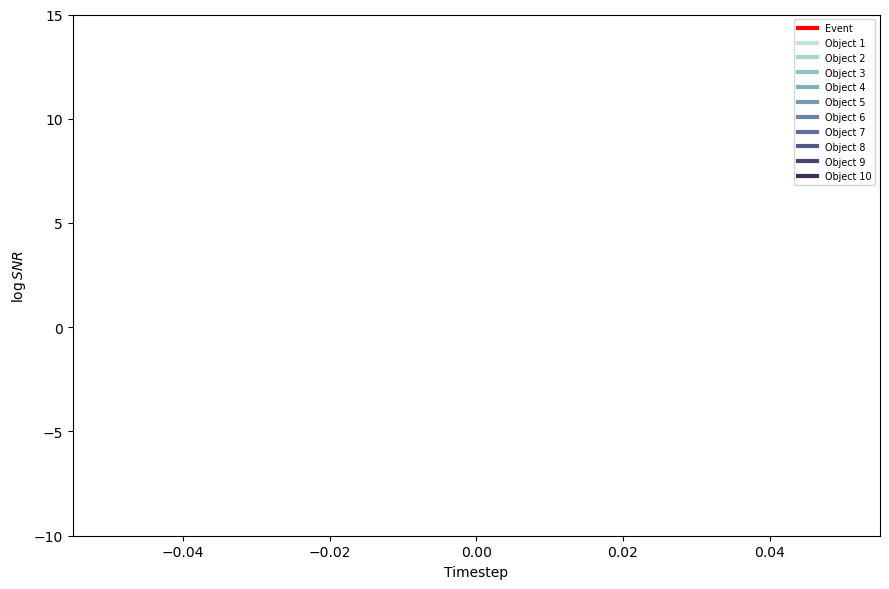

In [36]:
cmap = sb.cubehelix_palette(n_colors=max_particle_vectors, start=.5, rot=-.5)
cmap = [(1.0, 0.0, 0.0)] + cmap

fig = plt.figure(figsize=(9, 6))
for i, γ in enumerate(gamma[:, :, 0].T):
    plt.plot(timesteps[:, 0], -γ, c=cmap[i], label=f"Object {i}" if i > 0 else "Event", linewidth=3);
    
plt.xlabel("Timestep")
plt.ylabel("$\log{SNR}$")
plt.yticks([-10, -5, 0, 5, 10, 15])
plt.legend(fontsize="x-small")
# plt.title("Learned Multi-Object Noise Schedule")
plt.tight_layout()
plt.savefig("noise_schedule.png", dpi=300, bbox_inches="tight")
plt.savefig("noise_schedule.pdf", bbox_inches="tight")

In [37]:
timesteps = np.linspace(0, 1, 1024)
timesteps = jnp.broadcast_to(timesteps[:, None], (timesteps.shape[0], 10))
gamma = np.asarray(network.noise_schedule(timesteps, *network.gamma_limits())).astype(np.float64)

log_alphas_cumprod = special.log_expit(-gamma)
log_alphas = np.diff(log_alphas_cumprod, prepend=0, axis=0)
betas = -np.expm1(log_alphas)[:, None, :]
betas = jnp.array(betas.astype(np.float32))
betas = betas.at[0].set(betas[1])

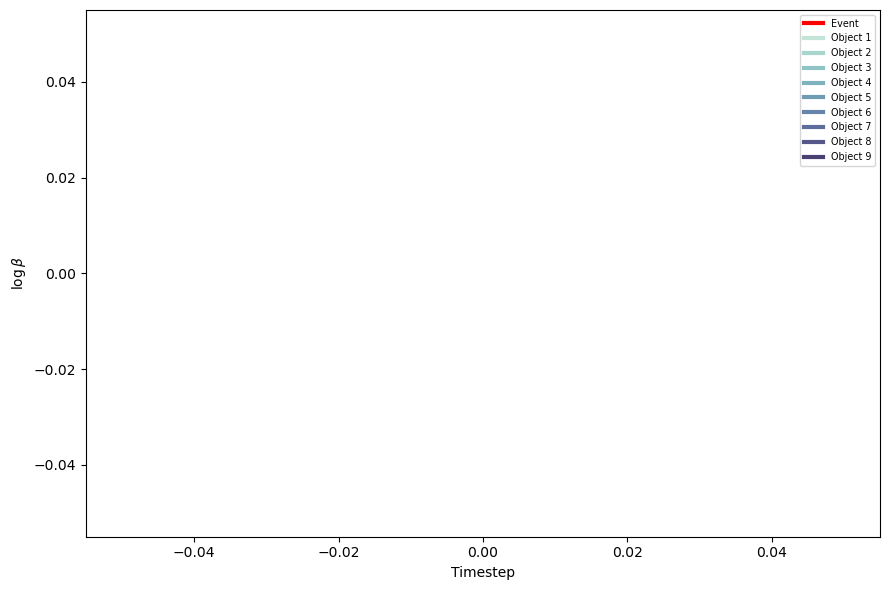

In [38]:
cmap = sb.cubehelix_palette(n_colors=max_particle_vectors, start=.5, rot=-.5)
cmap = [(1.0, 0.0, 0.0)] + cmap

fig = plt.figure(figsize=(9, 6))
for i, γ in enumerate(betas.reshape(timesteps.shape).T):
    plt.plot(timesteps[:, 0], np.log(γ), c=cmap[i], label=f"Object {i}" if i > 0 else "Event", linewidth=3);
    
plt.xlabel("Timestep")
plt.ylabel("$\\log \\beta$")
plt.legend(fontsize="x-small")
plt.tight_layout()
plt.savefig("betas.png", dpi=300, bbox_inches="tight")
plt.savefig("betas.pdf", bbox_inches="tight")

## Perform Diffusion

In [39]:
GEN_STEPS = 1000
GEN_VECTORS = 11
NUM_OVERSAMPLES = 128
BATCH_SIZE = config.training.batch_size // 2

NUM_DEVICES = len(jax.devices())
NUM_OVERSAMPLE_PER_DEVICE = max(NUM_OVERSAMPLES // NUM_DEVICES, 1)
NUM_OVERSAMPLES = NUM_OVERSAMPLE_PER_DEVICE * NUM_DEVICES

oversample_in_axes = (None, None, None, None, None, None, None, None, None, 0)
oversample_static_argnums = (4, 5)

oversample_ode = jax.pmap(
    jax.vmap(trainer.generate.discrete, in_axes=oversample_in_axes),
    in_axes=oversample_in_axes,
    static_broadcasted_argnums=oversample_static_argnums,
)

oversample_reconstruct = jax.pmap(
    jax.vmap(trainer.reconstruct, in_axes=(None, None, 0)),
    in_axes=(None, None, 0)
)

In [40]:
if RUN_DIFFUSION:
    outputs = []
    key = jax.vmap(jax.random.split, in_axes=(0, None))(jax.random.split(state.seed, NUM_DEVICES), NUM_OVERSAMPLE_PER_DEVICE)
    
    def expand_oversample(arr):
        return jnp.broadcast_to(arr[None], (NUM_OVERSAMPLES, *arr.shape))
    
    for batch in tqdm(testing_dataset.single_device_dataloader(batch_size=BATCH_SIZE), total=testing_dataset.num_events // BATCH_SIZE):
        output, key = oversample_ode(
            state,
            batch.detector_vectors,
            batch.detector_mask,
            batch.detector_event,
            GEN_VECTORS,
            GEN_STEPS,
            guidance_scale,
            betas,
            batch.particle_mask.sum(-1) + 1,
            key
        )
     
        outputs.append(jax.tree_map(np.array, output))

0it [00:00, ?it/s]


ValueError: Incompatible shapes for broadcasting: (1, 10, 1) and requested shape (10, 11, 1)

In [22]:
if RUN_DIFFUSION:
    def transponse_oversample(arr):
        arr = arr.reshape(NUM_OVERSAMPLES, *arr.shape[2:])
        return np.swapaxes(arr, 0, 1)
    
    output = jax.tree_map(lambda *x: np.concatenate(x, axis=2), *outputs)
    output = jax.tree_map(transponse_oversample, output)
    
    with lz4.frame.open(f"{OUTPUT_FOLDER}/outputs_oversample_{guidance_scale}.lz4", mode='wb') as file:
        pickle.dump(output, file)

In [23]:
glob(f"{OUTPUT_FOLDER}/outputs_oversample_*")

[]

In [24]:
try:
    print(len(outputs))
except NameError:
    if os.path.exists(f"{OUTPUT_FOLDER}/outputs_oversample_{guidance_scale}.lz4"):
        with lz4.frame.open(f"{OUTPUT_FOLDER}/outputs_oversample_{guidance_scale}.lz4", 'rb') as file:
            output = pickle.load(file)

In [25]:
preprocessing_file = TESTING_DATASET.replace(".test.npz", ".preprocessing")

# if os.path.exists(preprocessing_file):
#     print(preprocessing_file)
#     with open(preprocessing_file, 'rb') as file:
#         detector_vector_transform, detector_met_transform, particle_vector_transform, particle_met_transform = pickle.load(file)

# else:
print("No Preprocessing")
detector_vector_transform = FunctionTransformer(lambda x: x, lambda x: x)
detector_met_transform = FunctionTransformer(lambda x: x, lambda x: x)
particle_vector_transform = FunctionTransformer(lambda x: x, lambda x: x)
particle_met_transform = FunctionTransformer(lambda x: x, lambda x: x)

No Preprocessing


In [26]:
def transform_particle(vectors, mask):
    return mask[..., None] * particle_vector_transform.inverse_transform(vectors.reshape(-1, vectors.shape[-1])).reshape(vectors.shape)

def transform_detector(vectors, mask):
    return mask[..., None] * detector_vector_transform.inverse_transform(vectors.reshape(-1, vectors.shape[-1])).reshape(vectors.shape)

def transform_particle_met(vectors):
    return particle_met_transform.inverse_transform(vectors.reshape(-1, vectors.shape[-1])).reshape(vectors.shape)

def transform_detector_met(vectors):
    return detector_met_transform.inverse_transform(vectors.reshape(-1, vectors.shape[-1])).reshape(vectors.shape)

## Extract Kinematics

In [27]:
pred_vectors = transform_particle(output.vectors, output.mask).astype(np.float64)
num_events = pred_vectors.shape[0]

true_vectors = transform_particle(testing_dataset.particle_vectors, testing_dataset.particle_mask).astype(np.float64)[:num_events]
true_detector = transform_detector(testing_dataset.detector_vectors, testing_dataset.detector_mask).astype(np.float64)[:num_events]

pred_types = output.type_logits.argmax(-1)
true_types = testing_dataset.particle_types[:num_events]
detector_types = testing_dataset.detector_vectors[:, :,  -4:].argmax(-1)[:num_events]

pred_mask = output.mask
true_mask = testing_dataset.particle_mask[:num_events]
detector_mask = testing_dataset.detector_mask[:num_events]

pred_event = transform_particle_met(output.event).astype(np.float64)
true_event = transform_particle_met(testing_dataset.particle_event).astype(np.float64)[:num_events]
detector_event = transform_detector_met(testing_dataset.detector_event).astype(np.float64)[:num_events]

pred_event = np.pad(pred_event, ((0, 0), (0, 0), (0, 1)), constant_values=0)
true_event = np.pad(true_event, ((0, 0), (0, 1)), constant_values=0)

NameError: name 'output' is not defined

In [ ]:
def load_dataset(dataset):
    values = dataset[:]
    if values.dtype == np.float64:
        values = values.astype(np.float32)
    
    if values.dtype == np.int32:
        values = values.astype(np.int64)
    
    return values

def read(file, level=0, path = [], verbose: bool = True):
    if isinstance(file, h5py.Dataset):
        return load_dataset(file)

    database = {}
    
    iterator = file
    if level == 1 and verbose:
        iterator = tqdm(file, f"Loading {path[-1]}")
        
    for key in iterator:
        database[key] = read(file[key], level + 1, path + [key], verbose=verbose)

    return database

base_dataset_name = TESTING_DATASET.split("/")[-1].split(".")[0]
base_dataset_type = TESTING_DATASET.split("/")[-1].split(".")[-2]
base_dataset_name = base_dataset_name.replace("_VAE", "")
base_dataset_name = base_dataset_name.replace("_ORACLE", "")

raw_dataset = glob(f"../dataset/raw/{base_dataset_name}.h5")[0]

with h5py.File(raw_dataset) as file:
    raw_dataset = read(file["partonlevel"])
    raw_detector = read(file["recolevel"])
    raw_particle_mask = np.concatenate((
        file["particlelevel"]["electrons"]["mask"][:],
        file["particlelevel"]["muons"]["mask"][:],
        file["particlelevel"]["jets"]["mask"][:]
    ), axis=1)

    raw_detector_mask = np.concatenate((
        file["recolevel"]["electrons"]["mask"][:],
        file["recolevel"]["muons"]["mask"][:],
        file["recolevel"]["jets"]["mask"][:]
    ), axis=1)

    mask = (raw_particle_mask.sum(1) > 0) & (raw_detector_mask.sum(1) > 0)

    raw_dataset = jax.tree_map(lambda x: x[mask], raw_dataset)
    raw_detector = jax.tree_map(lambda x: x[mask], raw_detector)
    
    if base_dataset_type == "test":
        raw_dataset = jax.tree_map(lambda x: x[-testing_dataset.num_events:], raw_dataset)
        raw_detector = jax.tree_map(lambda x: x[-testing_dataset.num_events:], raw_detector)

raw_dataset = jax.tree_map(lambda x: x[:true_mask.shape[0]], raw_dataset)
raw_detector = jax.tree_map(lambda x: x[:true_mask.shape[0]], raw_detector)

In [36]:
try:
    type_wm = np.abs(np.concatenate((raw_dataset["Wm"]["d1"]["pid"], raw_dataset["Wm"]["d2"]["pid"]), axis=1))
    type_wp = np.abs(np.concatenate((raw_dataset["Wp"]["d1"]["pid"], raw_dataset["Wp"]["d2"]["pid"]), axis=1))
    wm_mask = ((type_wm <= 6) & (type_wm >= 1)).all(1) & ((type_wp <= 16) & (type_wp >= 11)).all(1)
    wp_mask = ((type_wp <= 6) & (type_wp >= 1)).all(1) & ((type_wm <= 16) & (type_wm >= 11)).all(1)
    topology_mask = (wp_mask ^ wm_mask)
    
    pred_vectors = pred_vectors[topology_mask]
    true_vectors = true_vectors[topology_mask]
    true_detector = true_detector[topology_mask]

    pred_types = pred_types[topology_mask]
    true_types = true_types[topology_mask]
    detector_types = detector_types[topology_mask]

    pred_mask = pred_mask[topology_mask]
    true_mask = true_mask[topology_mask]
    detector_mask = detector_mask[topology_mask]

    pred_event = pred_event[topology_mask]
    true_event = true_event[topology_mask]
    detector_event = detector_event[topology_mask]

    raw_dataset = jax.tree_map(lambda x: x[topology_mask], raw_dataset)
    raw_detector = jax.tree_map(lambda x: x[topology_mask], raw_detector)
except NameError:
    pass

In [37]:
KINEMATICS_DIMENSIONS = 5
def extract_kinematics(vectors):
    kinematics = vector.array({
        "px": vectors[..., 0],
        "py": vectors[..., 1],
        "pz": vectors[..., 2],
        # "energy": np.expm1(vectors[..., 3])
        "mass": np.expm1(vectors[..., -1])
    })

    return vector.array({
        "pt": kinematics.pt,
        "eta": kinematics.eta,
        "phi": kinematics.phi,
        "mass": kinematics.mass,
    })

def extract_detector_kinematics(vectors):
    return vector.array({
        "px": vectors[..., 0],
        "py": vectors[..., 1],
        "pz": vectors[..., 2],
        "energy": np.expm1(vectors[..., 3])
    })

In [38]:
all_pred_kinematics = extract_kinematics(pred_vectors)
all_true_kinematics = extract_kinematics(true_vectors)
all_detector_kinematics = extract_detector_kinematics(true_detector)

In [39]:
def masking_function(vectors, mask, types):
    pt_jet_mask = vectors.pt >= 25
    eta_jet_mask = np.abs(vectors.eta) <= 4.9
    mask = mask & pt_jet_mask & eta_jet_mask
    types = types - (~mask)
    
    count_mask = ((types >= 0) & (types <= 1)).sum(-1) >= 4  # At least 4 hard jets
    lepton_mask = (types > 1).sum(-1) == 1  # Exactly 1 lepton
    b_mask = (types == 1).sum(-1) >= 2      # At least two of the jets are b-quarks
    event_mask = count_mask & lepton_mask & b_mask

    return event_mask[..., None] & mask

raw_true_mask = true_mask
raw_pred_mask = pred_mask
raw_detector_mask = detector_mask

true_mask = masking_function(all_true_kinematics, true_mask, true_types)
pred_mask = masking_function(all_pred_kinematics, pred_mask, pred_types)
detector_mask = masking_function(all_detector_kinematics, detector_mask, detector_types)

In [40]:
pred_met = np.expm1(pred_event[..., 0])
pred_met_phi = np.arctan2(pred_event[..., 1], pred_event[..., 2])

true_met = np.expm1(true_event[:, 0])
true_met_phi = np.arctan2(true_event[:, 1], true_event[:, 2])

detector_met = np.expm1(detector_event[:, 0])
detector_met_phi = np.arctan2(detector_event[:, 1], detector_event[:, 2])

idx = 3

pred_hadronic_top = extract_kinematics(pred_event[..., idx:idx+KINEMATICS_DIMENSIONS])
true_hadronic_top = extract_kinematics(true_event[..., idx:idx+KINEMATICS_DIMENSIONS])

idx = idx + KINEMATICS_DIMENSIONS
pred_leptonic_top = extract_kinematics(pred_event[..., idx:idx+KINEMATICS_DIMENSIONS])
true_leptonic_top = extract_kinematics(true_event[..., idx:idx+KINEMATICS_DIMENSIONS])

idx = idx + KINEMATICS_DIMENSIONS
pred_neutrino = extract_kinematics(pred_event[..., idx:idx+KINEMATICS_DIMENSIONS])
true_neutrino = extract_kinematics(true_event[..., idx:idx+KINEMATICS_DIMENSIONS])

# Unfolding Plots

### Plotting Code

The insanely complicated plotting code to make the plots in the paper. Here be dragons.

In [63]:
class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.1f"  # Give format here

    def __call__(self, x, pos=None):
        if x == 0:
            return ""
        else:
            return super().__call__(x, pos)

class ScalarFormatterForceFormatSimple(ScalarFormatter):
    def __call__(self, x, pos=None):
        if x == 0:
            return ""
        else:
            return super().__call__(x, pos)
        
def simple_hist(
    true, 
    pred, 
    detector = None, 
    
    true_mask = None,
    pred_mask = None,
    detector_mask = None,
    
    bins=128, 
    alpha=0.1, 
    beta=3, 
    ranges=None,
    hist_yrange=None,
    scatter_yrange=None,
    log_scale = True,
    xlabel = None,
    save = None,
    score = False,
    density=True,
    mask_names = None,
    mask_name_location = None,
    base_width=None,
    compare=COMPARE_FOLDER,
    fontsize=None
):
    if not isinstance(true_mask, list):
        true_mask = [true_mask]
    if not isinstance(pred_mask, list):
        pred_mask = [pred_mask]
    if not isinstance(detector_mask, list):
        detector_mask = [detector_mask]

    num_plots = len(true_mask)

    if mask_names is None:
        mask_names = [None] * num_plots

    BASE_SIZE = 6
    if base_width is None:
        base_width = BASE_SIZE
        
    has_compare = compare is not None
    true_color = "b" if not has_compare else "m"
    unfolded_color = "r" if not has_compare else "orange"
    detector_color = "g"

    is_eft = "EFT" in OUTPUT_FOLDER
    is_vae = "VAE" in OUTPUT_FOLDER
    true_label = "EFT Truth" if is_eft else "SM Truth"
    detector_label = "EFT Detector" if is_eft else "SM Detector"
    unfolded_label = "Unfolded" if not has_compare else ("VAE" if is_vae else ("EFT Unfolded" if is_eft else "SM Unfolded"))

    fig, axes = plt.subplots(
        nrows=2, 
        ncols=num_plots, 
        height_ratios=(1.8, 1), 
        sharex=False, 
        squeeze=False, 
        figsize=(base_width * num_plots, BASE_SIZE)
    )

    base_true = true
    base_pred = pred
    base_detector = detector
    
    for plot_num, (true_mask, pred_mask, detector_mask, mask_name) in enumerate(zip(true_mask, pred_mask, detector_mask, mask_names)):
        true = base_true
        pred = base_pred
        detector = base_detector
        
        ax1 = axes[0, plot_num]
        ax2 = axes[1, plot_num]
        
        if true_mask is not None:
            true = true[true_mask]
    
        if detector is not None and detector_mask is not None:
            detector = detector[detector_mask]
    
        if ranges is None:
            xmin = np.percentile(true, alpha)
            xmax = np.percentile(true, 100.0 - alpha)
        else:
            xmin, xmax = ranges
            
        yt, x = np.histogram(true, bins=bins, range=(xmin, xmax), density=density)
        if detector is not None:
            yd, _  = np.histogram(detector, bins=bins, range=(xmin, xmax), density=density)            
    
        if score:
            true_for_metrics = true[(true >= xmin) & (true <= xmax)]
            
        if pred.ndim > true.ndim:
            yps = []
            predicted_scores = []
            
            for i in range(pred.shape[1]):
                current_pred = pred[:, i]
                if pred_mask is not None:
                    current_pred = current_pred[pred_mask[:, i]]
                    
                yp, _ = np.histogram(current_pred, bins=bins, range=(xmin, xmax), density=density)
                yps.append(yp)
    
                if score:
                    current_pred = current_pred[(current_pred >= xmin) & (current_pred <= xmax)]
                    EM = ot.emd2_1d(true_for_metrics, current_pred, metric="euclidean")
                    ED = stats.energy_distance(true_for_metrics, current_pred)
                    KL = np.sum(yt * np.log(yt / yp), where=(yt > 0) & (yp > 0))
                    predicted_scores.append((EM, ED, KL))
    
            yps = np.array(yps)
            predicted_scores = np.array(predicted_scores)
            
            ypm = yps.mean(0)
            ypu = yps.max(0)
            ypl = yps.min(0)
    
        x = (x[1:] + x[:-1]) / 2

        lines = []
        line_names = []
        
        l2, = ax1.plot(x, ypm, color=unfolded_color, linestyle='-', label=unfolded_label, linewidth=3)
        ax1.fill_between(x, ypl, ypu, color=unfolded_color, alpha=0.2)
        ax1.plot(x, ypl, color=unfolded_color, linestyle='--', alpha=0.4, linewidth=2)
        ax1.plot(x, ypu, color=unfolded_color, linestyle='--', alpha=0.4, linewidth=2)
        lines.append(l2)
        line_names.append(unfolded_label)
        
        ax2.plot(x, np.log(ypm / yt), color=unfolded_color, linestyle='-', linewidth=3)
        ax2.fill_between(x, np.log(ypl / yt), np.log(ypu / yt), color=unfolded_color, alpha=0.2)
        ax2.plot(x, np.log(ypl / yt), color=unfolded_color, linestyle='--', alpha=0.4, linewidth=2)
        ax2.plot(x, np.log(ypu / yt), color=unfolded_color, linestyle='--', alpha=0.4, linewidth=2)

        l1, = ax1.plot(x, yt, color=true_color, linestyle='--', label=true_label, linewidth=4)
        lines.append(l1)
        line_names.append(true_label)

        if detector is not None:
            l3, = ax1.plot(x, yd, color=detector_color, linestyle=":", label=detector_label, linewidth=3)
            ax2.plot(x, np.log(yd / yt), color=detector_color, linestyle=":", linewidth=3)
            lines.append(l3)
            line_names.append(detector_label)
            
        if compare is not None:
            comp_data = np.load(f"{compare}/{save}.{plot_num}.npz")

            comp_is_eft = "EFT" in compare
            comp_true_label = "EFT Truth" if comp_is_eft else "SM Truth"
            comp_detector_label = "EFT Detector" if comp_is_eft else "SM Detector"
            comp_unfolded_label = "Unfolded" if not has_compare else ("EFT Unfolded" if comp_is_eft else "SM Unfolded")

            l4, = ax1.plot(comp_data["x"], comp_data["ypm"], color='r', linestyle='-', label=comp_unfolded_label, linewidth=3)
            ax2.plot(x, np.log(comp_data["ypm"] / yt), color='r', linestyle='-', linewidth=3)
            lines.append(l4)
            line_names.append(comp_unfolded_label)
            
            if not is_vae:
                l5, = ax1.plot(comp_data["x"], comp_data["yt"], color='b', linestyle='--', label=comp_true_label, linewidth=4)
                ax2.plot(x, np.log(comp_data["yt"] / yt), color='b', linestyle='--', linewidth=3)

                lines.append(l5)
                line_names.append(comp_true_label)
        
        ax2.hlines(0.0, xmin, xmax, linestyle='--', colors='m')

        ax1.set_ylabel("Density" if density else "Count")
        ax2.set_ylabel("Log Ratio")
        ax1.set_xlim(xmin, xmax)
        ax2.set_xlim(xmin, xmax)
        
        if log_scale:
            ax1.set_yscale("log")
            ax1.set_ylabel("Density (Log Scale)")
                
        if hist_yrange is not None:
            ax1.set_ylim(*hist_yrange)
    
        if scatter_yrange is not None:
            ax2.set_ylim(*scatter_yrange)

        if has_compare:
            if num_plots > 1:
                plt.figlegend(lines, line_names, bbox_to_anchor=(0, 0, 0.95, 0.92), fontsize="x-small" if fontsize is None else fontsize)
            elif num_plots == 1:
                ax1.legend(fontsize="small" if fontsize is None else fontsize)

        else:       
            if num_plots > 1:
                if detector is not None:
                    plt.figlegend(lines, line_names, bbox_to_anchor=(0, 0, 0.95, 0.92), fontsize="small" if fontsize is None else fontsize)
            elif num_plots == 1:
                    ax1.legend(fontsize="small" if fontsize is None else fontsize)
            
        if plot_num == (num_plots - 1):
            if xlabel is not None:
                ax2.set_xlabel(xlabel)

        if plot_num == 0:    
            ax1.ticklabel_format(style="scientific", scilimits=(0, 0), useMathText=True, axis="y")
            ax1.ticklabel_format(useMathText=True, axis="x")
            ax2.ticklabel_format(useMathText=True)
            yfmt = ScalarFormatterForceFormat()
            yfmt.set_powerlimits((0,0))
            ax1.yaxis.set_major_formatter(yfmt)
            ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:1.2f}' if bins == 10 else '{x:1.1f}'))
            
            fig.align_ylabels([ax1, ax2])

            max_ylim = ax1.get_ylim()[1]            

        else:
            yfmt = ScalarFormatterForceFormatSimple()
            ax2.xaxis.set_major_formatter(yfmt)
            
            ax1.set_ylabel(None)
            ax2.set_ylabel(None)
            
            ax1.set_yticklabels([])
            ax2.set_yticklabels([])

        ax1.set_xlabel(None)
        ax1.set_xticklabels([])
        ax1.set_ylim(0, max_ylim)

        if mask_name is not None:
            x1, x2 = ax1.get_xlim()
            xd = x2 - x1
            xm = x1 + mask_name_location[0] * xd
            
            ax1.text(xm, mask_name_location[1] * ax1.get_ylim()[1], mask_name)

        if save is not None:
            np.savez(
                f"{OUTPUT_FOLDER}/{save}.{plot_num}.npz", 
                x=x, yt=yt, ypm=ypm, ypl=ypl, ypu=ypu, yd=yd if detector is not None else None
            )
            
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.0, right=0.96)
        
    if save is not None:
        plt.savefig(f"{OUTPUT_FOLDER}/{save}.png", dpi=300)
        plt.savefig(f"{OUTPUT_FOLDER}/{save}.pdf")
        np.savez(f"{OUTPUT_FOLDER}/{save}.npz", x=x, yt=yt, ypm=ypm, ypl=ypl, ypu=ypu, yd=yd if detector is not None else None)
        
        if score:
            with open(f"{OUTPUT_FOLDER}/{save}.txt", 'w') as score_file:
                for metric in predicted_scores.T:
                    print(f"{metric.mean():.5f} [{metric.min():.5f}, {metric.max():.5f}]", end="\t", file=score_file)
                print(file=score_file)

                if detector is not None:
                    detector_for_metrics = detector[(detector >= xmin) & (detector <= xmax)]
                    EM = ot.emd2_1d(true_for_metrics, detector_for_metrics, metric="euclidean")
                    ED = stats.energy_distance(true_for_metrics, detector_for_metrics)
                    KL = np.sum(yt * np.log(yt / yd), where=(yt > 0) & (yd > 0))
                    print(f"{EM:.5f}\t{ED:.5f}\t{KL:.5f}", file=score_file)
                
    return predicted_scores, fig, (ax1, ax2)

### Plotting Config
Prepare for plotting. We're going to be using mplhep to use the ATLAS plotting style.

In [64]:
BINS = 64
SCORE = False

os.makedirs(f"{OUTPUT_FOLDER}/event/", exist_ok=True)
os.makedirs(f"{OUTPUT_FOLDER}/jets/", exist_ok=True)
os.makedirs(f"{OUTPUT_FOLDER}/jets_split/", exist_ok=True)
os.makedirs(f"{OUTPUT_FOLDER}/leptons/", exist_ok=True)
os.makedirs(f"{OUTPUT_FOLDER}/observables/", exist_ok=True)  
os.makedirs(f"{OUTPUT_FOLDER}/assignment/", exist_ok=True)
sb.set_theme(context="paper", style="whitegrid", font_scale=2.4, rc={"figure.figsize": (6, 6)})
mplhep.style.use("ATLAS")
mpl.rcParams["figure.figsize"] = (6, 6)
mpl.rcParams["text.usetex"] = True
mpl.rcParams["axes.grid"] = True
mpl.rcParams["axes.grid.axis"] = "x"
mpl.rcParams["font.size"] = 18.0
mpl.rcParams["font.family"] = "Computer Modern"

## Hadronic Top

In [ ]:
predicted_scores, *_ = simple_hist(
    true_hadronic_top.pt, 
    pred_hadronic_top.pt, 
    bins=BINS, 
    ranges=(0, 500),
    scatter_yrange=(-0.5, 0.5),
    log_scale=False, 
    xlabel="Parton Hadronic Top $P_\\mathrm{T}$ [GeV]",
    save="event/hadronic_top_pt"
)

simple_hist(
    true_hadronic_top.eta, 
    pred_hadronic_top.eta, 
    bins=BINS, 
    ranges=(-2.5, 2.5),
    scatter_yrange=(-0.5, 0.5),
    log_scale=False,
    xlabel="Parton Hadronic Top $\\eta$",
    save="event/hadronic_top_eta"
)

simple_hist(
    true_hadronic_top.phi, 
    pred_hadronic_top.phi, 
    bins=10, 
    ranges=(-3.1415, 3.1415),
    scatter_yrange=(-0.5, 0.5),
    hist_yrange=(0, 0.2),
    log_scale=False,
    xlabel="Parton Hadronic Top $\\phi$",
    save="event/hadronic_top_phi"
)

simple_hist(
    true_hadronic_top.mass, 
    pred_hadronic_top.mass, 
    bins=BINS, 
    alpha=1,
    ranges=(50, 350),
    scatter_yrange=(-2, 2),
    log_scale=False,
    xlabel="Parton Hadronic Top Mass [GeV]",
    save="event/hadronic_top_mass"
)

## Leptonic Top

In [ ]:
simple_hist(
    true_leptonic_top.pt, 
    pred_leptonic_top.pt, 
    bins=BINS, 
    ranges=(0, 500),
    scatter_yrange=(-0.5, 0.5),
    log_scale=False, 
    xlabel="Parton Leptonic Top $p_\\mathrm{T}$ [GeV]",
    save="event/leptonic_top_pt"
)

simple_hist(
    true_leptonic_top.eta, 
    pred_leptonic_top.eta, 
    bins=BINS, 
    ranges=(-2.5, 2.5),
    scatter_yrange=(-0.5, 0.5),
    log_scale=False,
    xlabel="Parton Leptonic Top $\\eta$",
    save="event/leptonic_top_eta"
)

simple_hist(
    true_leptonic_top.phi, 
    pred_leptonic_top.phi, 
    bins=10, 
    ranges=(-3.1415, 3.1415),
    scatter_yrange=(-0.5, 0.5),
    hist_yrange=(0, 0.2),
    log_scale=False,
    xlabel="Parton Leptonic Top $\\phi$",
    save="event/leptonic_top_phi"
)

simple_hist(
    true_leptonic_top.mass, 
    pred_leptonic_top.mass, 
    bins=BINS, 
    alpha=1,
    ranges=(50, 350),
    scatter_yrange=(-2, 2),
    log_scale=False,
    xlabel="Parton Leptonic Top Mass [GeV]",
    save="event/leptonic_top_mass"
)

## Neutrino

In [ ]:
simple_hist(
    true_neutrino.pt, 
    pred_neutrino.pt, 
    bins=BINS, 
    scatter_yrange=(-0.5, 0.5), 
    ranges=(0, 300),
    log_scale=False, 
    xlabel="Neutrino $p_\\mathrm{T}$ [GeV]",
    save="event/neutrino_pt"
)

simple_hist(
    true_neutrino.eta, 
    pred_neutrino.eta, 
    bins=BINS, 
    ranges=(-2.5, 2.5),
    scatter_yrange=(-0.1, 0.1),
    log_scale=False, 
    xlabel="Neutrino $\\eta$",
    save="event/neutrino_eta"
)

simple_hist(
    true_neutrino.phi, 
    pred_neutrino.phi, 
    bins=10, 
    ranges=(-3.1415, 3.1415),
    scatter_yrange=(-0.5, 0.5),
    hist_yrange=(0, 0.2),
    log_scale=False, 
    xlabel="Neutrino $\\phi$",
    save="event/neutrino_phi"
)

## MET

In [ ]:
simple_hist(
    true_met, 
    pred_met, 
    detector_met, 
    bins=BINS, 
    scatter_yrange=(-0.25, 0.25), 
    ranges=(0, 300),
    log_scale=False, 
    xlabel="$E_\\mathrm{T}^\\mathrm{miss}$ [GeV]",
    save="event/met",
    score=SCORE
);

simple_hist(
    true_met_phi, 
    pred_met_phi, 
    detector_met_phi, 
    bins=10, 
    scatter_yrange=(-0.02, 0.02), 
    ranges=(-3.1415, 3.1415),
    hist_yrange=(0, 0.2),
    log_scale=False, 
    xlabel="$\\phi^\\mathrm{miss}$",
    save="event/phi",
    score=SCORE
);

## Jets

In [ ]:
simple_hist(
    all_true_kinematics.pt, 
    all_pred_kinematics.pt, 
    all_detector_kinematics.pt,
    pred_mask=pred_mask & (pred_types <= 1), 
    true_mask=true_mask & (true_types <= 1), 
    detector_mask=detector_mask & (detector_types <= 1),
    bins=BINS,
    ranges=(0, 400),
    scatter_yrange=(-0.2, 0.2),
    log_scale=False,
    xlabel="$p_\\mathrm{T}^\\mathrm{jet}$ [GeV]",
    save="jets/pt",
    score=SCORE
);

In [ ]:
simple_hist(
    all_true_kinematics.pt, 
    all_pred_kinematics.pt, 
    all_detector_kinematics.pt,
    pred_mask=[
        pred_mask & (pred_types <= 1) & (pred_mask.sum(-1, keepdims=True) <= 5), 
        pred_mask & (pred_types <= 1) & (pred_mask.sum(-1, keepdims=True) == 6), 
        pred_mask & (pred_types <= 1) & (pred_mask.sum(-1, keepdims=True) >= 7)
    ], 
    true_mask=[
        true_mask & (true_types <= 1) & (true_mask.sum(-1, keepdims=True) <= 5), 
        true_mask & (true_types <= 1) & (true_mask.sum(-1, keepdims=True) == 6), 
        true_mask & (true_types <= 1) & (true_mask.sum(-1, keepdims=True) >= 7)
    ], 
    detector_mask=[
        detector_mask & (detector_types <= 1) & (detector_mask.sum(-1, keepdims=True) <= 5), 
        detector_mask & (detector_types <= 1) & (detector_mask.sum(-1, keepdims=True) == 6), 
        detector_mask & (detector_types <= 1) & (detector_mask.sum(-1, keepdims=True) >= 7)
    ], 
    bins=BINS,
    ranges=(0, 400),
    scatter_yrange=(-0.2, 0.2),
    hist_yrange=(0, 3.0e-2),
    log_scale=False,
    xlabel="$p_\\mathrm{T}^\\mathrm{jet}$ [GeV]",
    save="jets_split/pt_by_n",
    score=SCORE,
    mask_names=["$N_{jets} \\leq 4$", "$N_{jets} = 5$", "$N_{jets} \\geq 6$"],
    mask_name_location=[0.15, 0.85],
    base_width=5
);

In [ ]:
simple_hist(
    all_true_kinematics.eta, 
    all_pred_kinematics.eta, 
    all_detector_kinematics.eta,
    pred_mask=pred_mask & (pred_types <= 1), 
    true_mask=true_mask & (true_types <= 1), 
    detector_mask=detector_mask & (detector_types <= 1),
    ranges=(-2.5, 2.5),
    bins=BINS,
    scatter_yrange=(-0.5, 0.5),
    log_scale=False,
    xlabel="$\\eta^\\mathrm{jet}$",
    save="jets/eta",
    score=SCORE
);

In [ ]:
simple_hist(
    all_true_kinematics.phi, 
    all_pred_kinematics.phi, 
    all_detector_kinematics.phi,
    pred_mask=pred_mask & (pred_types <= 1), 
    true_mask=true_mask & (true_types <= 1), 
    detector_mask=detector_mask & (detector_types <= 1),
    ranges=(-3.1415, 3.1415),
    hist_yrange=(0, 0.2),
    bins=10,
    scatter_yrange=(-0.02, 0.02),
    log_scale=False,
    xlabel="$\\phi^\\mathrm{jet}$",
    save="jets/phi",
    score=SCORE
);

In [ ]:
simple_hist(
    all_true_kinematics.mass, 
    all_pred_kinematics.mass, 
    all_detector_kinematics.mass,
    pred_mask=pred_mask & (pred_types <= 1), 
    true_mask=true_mask & (true_types <= 1), 
    detector_mask=detector_mask & (detector_types <= 1),
    ranges=(0, 60),
    scatter_yrange=(-1, 1),
    bins=BINS,
    log_scale=False,
    xlabel="$m^\\mathrm{jet}$ [GeV]",
    save="jets/mass",
    score=SCORE
);

In [ ]:
simple_hist(
    all_true_kinematics.mass, 
    all_pred_kinematics.mass, 
    all_detector_kinematics.mass,
    pred_mask=[
        pred_mask & (pred_types <= 1) & (pred_mask.sum(-1, keepdims=True) <= 5), 
        pred_mask & (pred_types <= 1) & (pred_mask.sum(-1, keepdims=True) == 6), 
        pred_mask & (pred_types <= 1) & (pred_mask.sum(-1, keepdims=True) >= 7)
    ], 
    true_mask=[
        true_mask & (true_types <= 1) & (true_mask.sum(-1, keepdims=True) <= 5), 
        true_mask & (true_types <= 1) & (true_mask.sum(-1, keepdims=True) == 6), 
        true_mask & (true_types <= 1) & (true_mask.sum(-1, keepdims=True) >= 7)
    ], 
    detector_mask=[
        detector_mask & (detector_types <= 1) & (detector_mask.sum(-1, keepdims=True) <= 5), 
        detector_mask & (detector_types <= 1) & (detector_mask.sum(-1, keepdims=True) == 6), 
        detector_mask & (detector_types <= 1) & (detector_mask.sum(-1, keepdims=True) >= 7)
    ], 
    ranges=(0, 50),
    scatter_yrange=(-1, 1),
    bins=BINS,
    log_scale=False,
    xlabel="$m^\\mathrm{jet}$ [GeV]",
    save="jets_split/mass_by_n",
    score=SCORE,
    mask_names=["$N_{jets} \\leq 4$", "$N_{jets} = 5$", "$N_{jets} \\geq 6$"],
    mask_name_location=[0.3, 0.8],
    base_width=5
);

In [ ]:
delta = np.abs(pred_mask.sum(-1, keepdims=True)[:, 0] - detector_mask.sum(-1, keepdims=True))

simple_hist(
    all_true_kinematics.mass, 
    all_pred_kinematics.mass[:, 0:1], 
    all_detector_kinematics.mass,
    pred_mask=[
        pred_mask[:, 0:1] & (pred_types[:, 0:1] <= 1) & (delta[:, None] == 0), 
        pred_mask[:, 0:1] & (pred_types[:, 0:1] <= 1) & (delta[:, None] == 1), 
        pred_mask[:, 0:1] & (pred_types[:, 0:1] <= 1) & (delta[:, None] >= 2)
    ], 
    true_mask=[
        true_mask & (true_types <= 1) & (delta == 0), 
        true_mask & (true_types <= 1) & (delta == 1), 
        true_mask & (true_types <= 1) & (delta >= 2)
    ], 
    detector_mask=[
        detector_mask & (detector_types <= 1) & (delta == 0), 
        detector_mask & (detector_types <= 1) & (delta == 1),
        detector_mask & (detector_types <= 1) & (delta >= 2)
    ], 
    ranges=(0, 50),
    scatter_yrange=(-1, 1),
    hist_yrange=(0, 1.2e-1),
    bins=BINS,
    log_scale=False,
    xlabel="$m^\\mathrm{jet}$  [GeV]",
    save="jets_split/mass_by_delta_n",
    score=SCORE,
    mask_names=["$|\\Delta N| = 0$", "$|\\Delta N| = 1$", "$|\\Delta N| \geq 2$"],
    mask_name_location=[0.3, 0.8],
    base_width=5
);

In [ ]:
simple_hist(
    all_true_kinematics.energy, 
    all_pred_kinematics.energy, 
    all_detector_kinematics.energy,
    pred_mask=pred_mask & (pred_types <= 1), 
    true_mask=true_mask & (true_types <= 1), 
    detector_mask=detector_mask & (detector_types <= 1),
    ranges=(0, 800),
    scatter_yrange=(-0.2, 0.2),
    bins=BINS,
    log_scale=False,
    xlabel="$E^\\mathrm{jet}$ [GeV]",
    save="jets/energy",
    score=SCORE
);

In [ ]:
simple_hist(
    all_true_kinematics.pz, 
    all_pred_kinematics.pz, 
    all_detector_kinematics.pz,
    pred_mask=pred_mask & (pred_types <= 1), 
    true_mask=true_mask & (true_types <= 1), 
    detector_mask=detector_mask & (detector_types <= 1),
    # ranges=(0, 800),
    alpha=1.0,
    bins=BINS,
    scatter_yrange=(-0.5, 0.5),
    log_scale=False,
    xlabel= "$p_z^\\mathrm{jet}$ [GeV]",
    save="jets/pz",
    score=SCORE
);

## Leptons

In [ ]:
simple_hist(
    all_true_kinematics.pt, 
    all_pred_kinematics.pt, 
    all_detector_kinematics.pt,
    pred_mask=pred_mask & (pred_types > 1), 
    true_mask=true_mask & (true_types > 1), 
    detector_mask=detector_mask & (detector_types > 1),
    ranges=(0, 200),
    bins=BINS,
    scatter_yrange=(-0.5, 0.5),
    log_scale=False,
    xlabel="$p_\\mathrm{T}^\\mathrm{lep}$ [GeV]",
    save="leptons/pt",
    score=SCORE
);

In [ ]:
simple_hist(
    all_true_kinematics.eta, 
    all_pred_kinematics.eta, 
    all_detector_kinematics.eta,
    pred_mask=pred_mask & (pred_types > 1), 
    true_mask=true_mask & (true_types > 1), 
    detector_mask=detector_mask & (detector_types > 1),
    ranges=(-2.5, 2.5),
    bins=BINS,
    scatter_yrange=(-0.5, 0.5),
    log_scale=False,
    xlabel="$\\eta^\\mathrm{lep}$",
    save="leptons/eta",
    score=SCORE
);

In [ ]:
simple_hist(
    all_true_kinematics.phi, 
    all_pred_kinematics.phi, 
    all_detector_kinematics.phi,
    pred_mask=pred_mask & (pred_types > 1), 
    true_mask=true_mask & (true_types > 1), 
    detector_mask=detector_mask & (detector_types > 1),
    ranges=(-3.1415, 3.1415),
    scatter_yrange=(-0.02, 0.02),
    hist_yrange=(0, 0.2),
    bins=10,
    log_scale=False,
    xlabel="$\\phi^\\mathrm{lep}$",
    save="leptons/phi",
    score=SCORE
);

In [ ]:
simple_hist(
    all_true_kinematics.mass, 
    all_pred_kinematics.mass, 
    all_detector_kinematics.mass,
    pred_mask=pred_mask & (pred_types > 1), 
    true_mask=true_mask & (true_types > 1), 
    detector_mask=detector_mask & (detector_types > 1),
    ranges=(0, 1),
    scatter_yrange=(-2, 2),
    bins=BINS,
    log_scale=False,
    xlabel="$m^\\mathrm{lep}$ [GeV]",
    save="leptons/mass",
    score=SCORE
);

In [ ]:
simple_hist(
    all_true_kinematics.energy, 
    all_pred_kinematics.energy, 
    all_detector_kinematics.energy,
    pred_mask=pred_mask & (pred_types > 1), 
    true_mask=true_mask & (true_types > 1), 
    detector_mask=detector_mask & (detector_types > 1),
    ranges=(0, 800),
    scatter_yrange=(-0.2, 0.2),
    bins=BINS,
    log_scale=False,
    xlabel="$E^\\mathrm{lep}$ [GeV]",
    save="leptons/energy",
    score=SCORE
);

In [ ]:
simple_hist(
    all_true_kinematics.pz, 
    all_pred_kinematics.pz, 
    all_detector_kinematics.pz,
    pred_mask=pred_mask & (pred_types > 1), 
    true_mask=true_mask & (true_types > 1), 
    detector_mask=detector_mask & (detector_types > 1),
    # ranges=(0, 800),
    scatter_yrange=(-0.2, 0.2),
    bins=BINS,
    log_scale=False,
    xlabel="$p_z^\\mathrm{lep}$ [GeV]",
    save="leptons/pz",
    score=SCORE
);

# Observable Plots

## Matching Algorithms

Several different matching algorithms implemented:
- Oracle - Based on distance from the partons
- Pseudo-Top - First estimate and match leptonic b and then hadronic b.
- Pseudo-Top with neutrino - Like before but use neutrino kinematics predictions instead of quadratic solution.

In [46]:
@numba.vectorize
def pid_to_type(arr):
    arr = np.abs(arr)
    if arr == 5:
        return 1
    elif arr == 11:
        return 2
    elif arr == 13:
        return 3
    elif arr == 15:
        return 4
    elif arr == 12:
        return 5
    elif arr == 14:
        return 5
    elif arr== 16:
        return 5
    else:
        return 0
        
def parton_to_vector(parton):
    return vector.array({
        "energy": parton["e"],
        "eta": parton["eta"],
        "phi": parton["phi"],
        "pt": parton["pt"]
    }), pid_to_type(parton["pid"])

@numba.njit(parallel=True)
def remove_indices(weights, indices, new_value):
    for i in numba.prange(weights.shape[0]):
        for j in range(weights.shape[1]):
            weights[i, j, indices[i]] += new_value

@numba.njit(parallel=True)
def count_unique(array, max_value):
    counts = np.zeros((array.shape[0], max_value), dtype=np.int64)
    for i in numba.prange(array.shape[0]):
        for j in range(array.shape[1]):
            counts[i, array[i, j]] += 1

    return counts
    
def oracle_match(dataset, particle_kinematics, particle_types, particle_mask):
    pid_m = np.abs(dataset["partonlevel"]["Wm"]["d2"]["pid"].ravel())
    anti_top_is_leptonic = pid_m > 10
    anti_top_is_hadronic = pid_m <= 10
    
    lb = tree.map_structure(
        lambda x, y: np.where(anti_top_is_leptonic, x.ravel(), y.ravel()), 
        dataset["partonlevel"]["antitop"]["d1"], 
        dataset["partonlevel"]["top"]["d1"]
    )
    
    ll = tree.map_structure(
        lambda x, y: np.where(anti_top_is_leptonic, x.ravel(), y.ravel()), 
        dataset["partonlevel"]["Wm"]["d1"], 
        dataset["partonlevel"]["Wp"]["d1"]
    )
    
    ln = tree.map_structure(
        lambda x, y: np.where(anti_top_is_leptonic, x.ravel(), y.ravel()), 
        dataset["partonlevel"]["Wm"]["d2"], 
        dataset["partonlevel"]["Wp"]["d2"]
    )
    
    hb = tree.map_structure(
        lambda x, y: np.where(anti_top_is_hadronic, x.ravel(), y.ravel()), 
        dataset["partonlevel"]["antitop"]["d1"], 
        dataset["partonlevel"]["top"]["d1"]
    )
    
    hq1 = tree.map_structure(
        lambda x, y: np.where(anti_top_is_hadronic, x.ravel(), y.ravel()), 
        dataset["partonlevel"]["Wm"]["d1"], 
        dataset["partonlevel"]["Wp"]["d1"]
    )
    
    hq2 = tree.map_structure(
        lambda x, y: np.where(anti_top_is_hadronic, x.ravel(), y.ravel()), 
        dataset["partonlevel"]["Wm"]["d2"], 
        dataset["partonlevel"]["Wp"]["d2"]
    )
    
    hb, hbt = parton_to_vector(hb)
    hq1, hq1t = parton_to_vector(hq1)
    hq2, hq2t = parton_to_vector(hq2)
    
    lb, lbt = parton_to_vector(lb)
    ll, llt = parton_to_vector(ll)
    ln, lnt = parton_to_vector(ln)
    
    partons = [hb, hq1, hq2, lb, ll, ln]
    parton_types = np.array([hbt, hq1t, hq2t, lbt, llt, lnt])

    pt_jet_mask = particle_kinematics.pt > 25
    eta_jet_mask = np.abs(particle_kinematics.eta) < 4.9
    particle_mask = particle_mask & pt_jet_mask & eta_jet_mask
    particle_types = (particle_mask * particle_types) - (~particle_mask)
    
    tau_mask = ~(parton_types == 4).any(0)
    neutrino_mask = (parton_types == 5).sum(0) == 1
    count_mask = ((particle_types >= 0) & (particle_types <= 1)).sum(1) >= 4  # At least 4 hard jets
    lepton_mask = (particle_types > 1).sum(1) == 1  # Exactly 1 lepton
    b_mask = (particle_types == 1).sum(1) >= 2      # At least two of the jets are b-quarks
    
    event_mask = tau_mask & count_mask & lepton_mask & b_mask & neutrino_mask
    
    weights = []
    for p, pt in zip(partons, parton_types):
        weight = particle_kinematics.deltaR(p[:, None])
        weight += np.where(particle_types == pt[:, None], 0.0, np.inf)
        weight += np.where(particle_mask, 0.0, np.inf)
        weights.append(weight)
    
    weights = np.stack(weights, axis=1)
    weights[:, 3] += particle_kinematics.deltaR(partons[4][:, None])
    
    MAX_OFFSET = 10 * np.max(weights, initial=0, where=np.isfinite(weights))
    weights = np.where(np.isfinite(weights), weights, MAX_OFFSET)

    llm = np.argmin(weights[:, 4] , axis=-1)
    remove_indices(weights, llm, MAX_OFFSET)
    
    lbm = np.argmin(weights[:, 3] , axis=-1)
    remove_indices(weights, lbm, MAX_OFFSET)
    
    hbm = np.argmin(weights[:, 0] , axis=-1)
    remove_indices(weights, hbm, MAX_OFFSET)
    
    hq1m = np.argmin(weights[:, 1] , axis=-1)
    remove_indices(weights, hq1m, MAX_OFFSET)
    
    hq2m = np.argmin(weights[:, 2] , axis=-1)
    remove_indices(weights, hq2m, MAX_OFFSET)

    dummy_indices = np.arange(particle_kinematics.shape[0])
    llp = particle_kinematics[dummy_indices, llm]
    lbp = particle_kinematics[dummy_indices, lbm]
    hbp = particle_kinematics[dummy_indices, hbm]
    hq1p = particle_kinematics[dummy_indices, hq1m]
    hq2p = particle_kinematics[dummy_indices, hq2m]
    lnp = ln
    
    ttbar = vector.array({
        "px": np.stack((hbp.px, hq1p.px, hq2p.px, lbp.px, llp.px, lnp.px), axis=1),
        "py": np.stack((hbp.py, hq1p.py, hq2p.py, lbp.py, llp.py, lnp.py), axis=1),
        "pz": np.stack((hbp.pz, hq1p.pz, hq2p.pz, lbp.pz, llp.pz, lnp.pz), axis=1),
        "mass": np.stack((hbp.mass, hq1p.mass, hq2p.mass, lbp.mass, llp.mass, lnp.mass), axis=1),
    })

    ttbar_mask = np.stack((
        particle_mask[dummy_indices, hbm],
        particle_mask[dummy_indices, hq1m],
        particle_mask[dummy_indices, hq2m],
        particle_mask[dummy_indices, lbm],
        particle_mask[dummy_indices, llm],
        np.isfinite(lnp.pz)
    ), axis=1)

    ttbar_mask = ttbar_mask & event_mask[:, None]
    
    return ttbar, ttbar_mask

In [47]:
def auto_match_b_quark(vectors, types, mask, met, met_phi, hard_mask: bool = True, pre_mask = None):
    # Apply Premask computed from global decision such as pass rate
    if pre_mask is not None:    
        pre_mask = pre_mask[:vectors.shape[0]]
        vectors = vectors[:pre_mask.shape[0]][pre_mask]
        mask = mask[:pre_mask.shape[0]][pre_mask]
        types = types[:pre_mask.shape[0]][pre_mask]
        met = met[:pre_mask.shape[0]][pre_mask]
        met_phi = met_phi[:pre_mask.shape[0]][pre_mask]

    # Limit events to those that pass pre-selection
    pt_jet_mask = vectors.pt > 25
    eta_jet_mask = np.abs(vectors.eta) < 4.9
    mask = mask & pt_jet_mask & eta_jet_mask
    types = (mask * types) - (~mask)
    
    count_mask = ((types >= 0) & (types <= 1)).sum(1) >= 4  # At least 4 hard jets
    lepton_mask = (types > 1).sum(-1) == 1  # Exactly 1 lepton
    b_mask = (types == 1).sum(-1) >= 2      # At least two of the jets are b-quarks
    event_mask = count_mask & lepton_mask & b_mask
    print(event_mask.mean())
    print((event_mask & (mask.sum(-1) == 5)).sum())
        
    if hard_mask:
        vectors = vectors[event_mask]
        mask = mask[event_mask]
        types = types[event_mask]
        met = met[event_mask]
        met_phi = met_phi[event_mask]
    
    DUMMY_INDEX = np.arange(vectors.shape[0])

    # Gather the highest pt leptons
    lepton_indices = (types > 1).argmax(1)
    lepton = vectors[DUMMY_INDEX, lepton_indices]
    lepton_type = types[DUMMY_INDEX, lepton_indices]
    
    nu_pt = met
    nu_px = met * np.cos(met_phi)
    nu_py = met * np.sin(met_phi)
    
    lepton_mass = np.where(lepton_type == 2, 5.109989461e-4, 0.1056583745)
    W_mass = 80.379
    
    alpha = (W_mass ** 2) - (lepton_mass ** 2) + 2 * (lepton.px * nu_px + lepton.py * nu_py)

    a = lepton.pz ** 2 - lepton.energy ** 2
    b = alpha * lepton.pz
    c = ( (alpha ** 2) / 4) - (lepton.energy ** 2) * (nu_pt ** 2)

    nu_pz = np.stack((
        (-b + np.sqrt(b ** 2 - 4 * a * c)) / (2 * a),
        (-b - np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)
    ), axis=-1)

    nu_pz = np.nan_to_num(nu_pz, nan=np.inf)
    nu_pz = nu_pz[DUMMY_INDEX, np.abs(nu_pz).argmin(-1)]

    neutrino = vector.array({
        "px": nu_px,
        "py": nu_py,
        "pz": nu_pz,
        "mass": np.zeros_like(nu_px)
    })[:, None]
    
    lepton = lepton[:, None]
    lepton_distance = vectors.deltaR(lepton) + np.where(types == 1, 0.0, np.inf)
    leptonic_b_indices = lepton_distance.argmin(1)
    leptonic_b = vectors[DUMMY_INDEX, leptonic_b_indices][:, None]

    hadronic_indices = np.copy(np.broadcast_to(np.arange(vectors.shape[1])[None, :], vectors.shape))
    hadronic_indices[DUMMY_INDEX, lepton_indices] += vectors.shape[1]
    hadronic_indices[DUMMY_INDEX, leptonic_b_indices] += vectors.shape[1]

    hadronic_b_indices = np.copy(hadronic_indices)
    hadronic_q_indices = np.copy(hadronic_b_indices)

    hadronic_b_indices[types != 1] += vectors.shape[1]
    hadronic_q_indices[types != 0] += vectors.shape[1]
    
    hadronic_b_indices = np.sort(hadronic_b_indices, axis=1)[:, :1]
    hadronic_q_indices = np.sort(hadronic_q_indices, axis=1)[:, :2]
    hadronic_indices = np.concatenate((hadronic_b_indices, hadronic_q_indices), axis=1)
    hadronic_indices[hadronic_indices >= vectors.shape[1]] = -1
    hadronic_top = vectors[DUMMY_INDEX[:, None], hadronic_indices]
    
    ttbar = vector.array({
        "px": np.concatenate((hadronic_top.px, leptonic_b.px, lepton.px, neutrino.px), axis=1),
        "py": np.concatenate((hadronic_top.py, leptonic_b.py, lepton.py, neutrino.py), axis=1),
        "pz": np.concatenate((hadronic_top.pz, leptonic_b.pz, lepton.pz, neutrino.pz), axis=1),
        "mass": np.concatenate((hadronic_top.mass, leptonic_b.mass, lepton.mass, neutrino.mass), axis=1)
    })

    print(hadronic_indices)
    ttbar_mask = np.concatenate((
        mask[DUMMY_INDEX[:, None], hadronic_indices],
        mask[DUMMY_INDEX, leptonic_b_indices][:, None],
        mask[DUMMY_INDEX, lepton_indices][:, None],
        np.isfinite(neutrino.pz)
    ), axis=1)

    if not hard_mask:
        ttbar_mask = ttbar_mask & event_mask[:, None]

    return ttbar, ttbar_mask

In [48]:
def auto_match_b_quark_with_neutrino(vectors, types, mask, event, hard_mask: bool = True, pre_mask = None):
    if pre_mask is not None:    
        pre_mask = pre_mask[:vectors.shape[0]]
        vectors = vectors[:pre_mask.shape[0]][pre_mask]
        mask = mask[:pre_mask.shape[0]][pre_mask]
        types = types[:pre_mask.shape[0]][pre_mask]
        event = event[:pre_mask.shape[0]][pre_mask]
    
    count_mask = mask.sum(1) >= 5
    lepton_mask = (types > 1).sum(1) >= 1
    b_mask = (types == 1).sum(1) >= 2
    event_mask = count_mask & lepton_mask & b_mask
    print(event_mask.mean())

    if hard_mask:
        vectors = vectors[event_mask]
        mask = mask[event_mask]
        types = types[event_mask]
        event = event[event_mask]
    
    DUMMY_INDEX = np.arange(vectors.shape[0])
    
    lepton_indices = (types > 1).argmax(1)
    lepton = vectors[DUMMY_INDEX, lepton_indices]
    lepton_type = types[DUMMY_INDEX, lepton_indices]

    neutrino = vector.array({
        "px": event[..., -4],
        "py": event[..., -3],
        "pz": event[..., -2],
        "mass": np.zeros_like(event[..., -2])
    })[:, None]

    lepton = lepton[:, None]
    lepton_distance = vectors.deltaR(lepton) + np.where(types == 1, 0.0, np.inf) + np.where(mask, 0.0, np.inf)
    leptonic_b_indices = lepton_distance.argmin(1)
    leptonic_b = vectors[DUMMY_INDEX, leptonic_b_indices][:, None]

    hadronic_indices = np.copy(np.broadcast_to(np.arange(vectors.shape[1])[None, :], vectors.shape))
    hadronic_indices[DUMMY_INDEX, lepton_indices] += vectors.shape[1]
    hadronic_indices[DUMMY_INDEX, leptonic_b_indices] += vectors.shape[1]

    hadronic_b_indices = np.copy(hadronic_indices)
    hadronic_q_indices = np.copy(hadronic_b_indices)

    hadronic_b_indices[types != 1] += vectors.shape[1]
    hadronic_q_indices[types != 0] += vectors.shape[1]
    
    hadronic_b_indices = np.sort(hadronic_b_indices, axis=1)[:, :1]
    hadronic_q_indices = np.sort(hadronic_q_indices, axis=1)[:, :2]
    hadronic_indices = np.concatenate((hadronic_b_indices, hadronic_q_indices), axis=1)
    hadronic_indices[hadronic_indices >= vectors.shape[1]] = -1
    hadronic_top = vectors[DUMMY_INDEX[:, None], hadronic_indices]
    
    ttbar = vector.array({
        "px": np.concatenate((hadronic_top.px, leptonic_b.px, lepton.px, neutrino.px), axis=1),
        "py": np.concatenate((hadronic_top.py, leptonic_b.py, lepton.py, neutrino.py), axis=1),
        "pz": np.concatenate((hadronic_top.pz, leptonic_b.pz, lepton.pz, neutrino.pz), axis=1),
        "mass": np.concatenate((hadronic_top.mass, leptonic_b.mass, lepton.mass, neutrino.mass), axis=1)
    })
    
    ttbar_mask = np.concatenate((
        mask[DUMMY_INDEX[:, None], hadronic_indices],
        mask[DUMMY_INDEX, leptonic_b_indices][:, None],
        mask[DUMMY_INDEX, lepton_indices][:, None],
        np.isfinite(neutrino.pz)
        # np.zeros_like(mask[DUMMY_INDEX, lepton_indices][:, None])
    ), axis=1)

    if not hard_mask:
        ttbar_mask = ttbar_mask & event_mask[:, None]

    return ttbar, ttbar_mask

## Match Datasets

Perform matching algorithm on unfolded datasets.

In [50]:
@numba.njit(parallel=True)
def permutation_index(array, permutations):
    output = np.empty_like(array)

    for i in numba.prange(array.shape[0]):
        output[i] = array[i, permutations[i]]

    return output
    
a, b, c = pred_mask.shape
pred_order = np.where(pred_mask.reshape(-1, c), all_pred_kinematics.pt.reshape(-1, c), -np.inf)
pred_permutations = np.argsort(pred_order, axis=-1)[..., ::-1]

sorted_all_pred_kinematics_pt = permutation_index(all_pred_kinematics.pt.reshape(-1, c), pred_permutations).reshape(a, b, c)
sorted_all_pred_kinematics_eta = permutation_index(all_pred_kinematics.eta.reshape(-1, c), pred_permutations).reshape(a, b, c)
sorted_all_pred_kinematics_phi = permutation_index(all_pred_kinematics.phi.reshape(-1, c), pred_permutations).reshape(a, b, c)
sorted_all_pred_kinematics_mass = permutation_index(all_pred_kinematics.mass.reshape(-1, c), pred_permutations).reshape(a, b, c)

sorted_all_pred_kinematics = vector.array({
    "pt": sorted_all_pred_kinematics_pt,
    "eta": sorted_all_pred_kinematics_eta,
    "phi": sorted_all_pred_kinematics_phi,
    "mass": sorted_all_pred_kinematics_mass
})

del sorted_all_pred_kinematics_pt
del sorted_all_pred_kinematics_eta
del sorted_all_pred_kinematics_phi
del sorted_all_pred_kinematics_mass

In [51]:
POST_OVERSAMPLE = 128
PRE_MASK_PERCENTAGE = 0.0

pred_count_mask = pred_mask.sum(-1) >= 5
pred_lepton_mask = (pred_types > 1).sum(-1) >= 1
pred_b_mask = (pred_types == 1).sum(-1) >= 2
pred_event_mask = pred_count_mask & pred_lepton_mask & pred_b_mask

detector_count_mask = detector_mask.sum(-1) >= 5
detector_lepton_mask = (detector_types > 1).sum(-1) >= 1
detector_b_mask = (detector_types == 1).sum(-1) >= 2
detector_event_mask = detector_count_mask & detector_lepton_mask & detector_b_mask

pred_event_pre_mask = pred_event_mask.mean(-1) >= PRE_MASK_PERCENTAGE

truth_event_pre_mask = None


### Pseudo-Top

In [ ]:
pred_matchings = [
    auto_match_b_quark(sorted_all_pred_kinematics[:, i], pred_types[:, i], pred_mask[:, i], pred_met[:, i], pred_met_phi[:, i], hard_mask=False, pre_mask=pred_event_pre_mask)
    for i in range(min(sorted_all_pred_kinematics.shape[1], POST_OVERSAMPLE))
]

pred_ttbar = vector.array({
    "px": np.stack([p[0].px for p in pred_matchings]),
    "py": np.stack([p[0].py for p in pred_matchings]),
    "pz": np.stack([p[0].pz for p in pred_matchings]),
    "energy": np.stack([p[0].energy for p in pred_matchings]),
})

pred_ttbar_mask = np.stack([p[1] for p in pred_matchings])

## Observable Definitions

Define all of our interesting observables in code

In [58]:
def hadronic_top_mass(pred_ttbar, pred_ttbar_mask):
    t_mass = pred_ttbar[..., :3].sum(-1).mass
    t_mask = pred_ttbar_mask[..., :3].all(-1)

    return t_mass, t_mask

def leptonic_top_mass(pred_ttbar, pred_ttbar_mask):
    t_mass = pred_ttbar[..., 3:].sum(-1).mass
    t_mask = pred_ttbar_mask[..., 3:].all(-1)

    return t_mass, t_mask

def both_top_mass(pred_ttbar, pred_ttbar_mask):
    t1_mass = pred_ttbar[..., :3].sum(-1).mass
    t2_mass = pred_ttbar[..., 3:].sum(-1).mass
    
    t1_mask = pred_ttbar_mask[..., :3].all(-1)
    t2_mask = pred_ttbar_mask[..., 3:].all(-1)
    
    t_mass = np.concatenate((t1_mass, t2_mass), axis=-1)
    t_mask = np.concatenate((t1_mask, t2_mask), axis=-1)

    return t_mass, t_mask

def ttbar_mass(pred_ttbar, pred_ttbar_mask):
    ttbar_mass = pred_ttbar.sum(-1).mass
    ttbar_mask = pred_ttbar_mask.all(-1)

    return ttbar_mass, ttbar_mask

def ttbar_pt(pred_ttbar, pred_ttbar_mask):
    ttbar_mass = pred_ttbar.sum(-1).pt
    ttbar_mask = pred_ttbar_mask.all(-1)

    return ttbar_mass, ttbar_mask

def ttbar_eta(pred_ttbar, pred_ttbar_mask):
    ttbar_mass = pred_ttbar.sum(-1).eta
    ttbar_mask = pred_ttbar_mask.all(-1)

    return ttbar_mass, ttbar_mask

def ttbar_phi(pred_ttbar, pred_ttbar_mask):
    ttbar_mass = pred_ttbar.sum(-1).phi
    ttbar_mask = pred_ttbar_mask.all(-1)

    return ttbar_mass, ttbar_mask

def ttbar_energy(pred_ttbar, pred_ttbar_mask):
    ttbar_mass = pred_ttbar.sum(-1).energy
    ttbar_mask = pred_ttbar_mask.all(-1)

    return ttbar_mass, ttbar_mask

def ttbar_y(pred_ttbar, pred_ttbar_mask):
    ttbar_mass = np.abs(pred_ttbar.sum(-1).rapidity)
    ttbar_mask = pred_ttbar_mask.all(-1)

    return ttbar_mass, ttbar_mask

def thad_pt(pred_ttbar, pred_ttbar_mask):
    ttbar_mass = pred_ttbar[..., :3].sum(-1).pt
    ttbar_mask = pred_ttbar_mask[..., :3].all(-1)

    return ttbar_mass, ttbar_mask


def thad_eta(pred_ttbar, pred_ttbar_mask):
    ttbar_mass = pred_ttbar[..., :3].sum(-1).eta
    ttbar_mask = pred_ttbar_mask[..., :3].all(-1)

    return ttbar_mass, ttbar_mask

def thad_phi(pred_ttbar, pred_ttbar_mask):
    ttbar_mass = pred_ttbar[..., :3].sum(-1).phi
    ttbar_mask = pred_ttbar_mask[..., :3].all(-1)

    return ttbar_mass, ttbar_mask

def thad_energy(pred_ttbar, pred_ttbar_mask):
    ttbar_mass = pred_ttbar[..., :3].sum(-1).energy
    ttbar_mask = pred_ttbar_mask[..., :3].all(-1)

    return ttbar_mass, ttbar_mask

def tlep_pt(pred_ttbar, pred_ttbar_mask):
    ttbar_mass = pred_ttbar[..., 3:].sum(-1).pt
    ttbar_mask = pred_ttbar_mask[..., 3:].all(-1)

    return ttbar_mass, ttbar_mask


def tlep_eta(pred_ttbar, pred_ttbar_mask):
    ttbar_mass = pred_ttbar[..., 3:].sum(-1).eta
    ttbar_mask = pred_ttbar_mask[..., 3:].all(-1)

    return ttbar_mass, ttbar_mask

def tlep_phi(pred_ttbar, pred_ttbar_mask):
    ttbar_mass = pred_ttbar[..., 3:].sum(-1).phi
    ttbar_mask = pred_ttbar_mask[..., 3:].all(-1)

    return ttbar_mass, ttbar_mask

def tlep_energy(pred_ttbar, pred_ttbar_mask):
    ttbar_mass = pred_ttbar[..., 3:].sum(-1).energy
    ttbar_mask = pred_ttbar_mask[..., 3:].all(-1)

    return ttbar_mass, ttbar_mask

def thad_y(pred_ttbar, pred_ttbar_mask):
    ttbar_mass = np.abs(pred_ttbar[..., :3].sum(-1).rapidity)
    ttbar_mask = pred_ttbar_mask[..., :3].all(-1)

    return ttbar_mass, ttbar_mask

def tlep_y(pred_ttbar, pred_ttbar_mask):
    ttbar_mass = np.abs(pred_ttbar[..., 3:].sum(-1).rapidity)
    ttbar_mask = pred_ttbar_mask[..., 3:].all(-1)

    return ttbar_mass, ttbar_mask

def t_pt(pred_ttbar, pred_ttbar_mask):
    t1_mass = pred_ttbar[..., :3].sum(-1).pt
    t2_mass = pred_ttbar[..., 3:].sum(-1).pt
    
    t1_mask = pred_ttbar_mask[..., :3].all(-1)
    t2_mask = pred_ttbar_mask[..., 3:].all(-1)
    
    t_mass = np.concatenate((t1_mass, t2_mass), axis=-1)
    t_mask = np.concatenate((t1_mask, t2_mask), axis=-1)

    return t_mass, t_mask

def ttbar_chi(pred_ttbar, pred_ttbar_mask):
    y1 = pred_ttbar[..., :3].sum(-1).rapidity
    y2 = pred_ttbar[..., 3:].sum(-1).rapidity
    y_star = 0.5 * (y1 - y2)
    
    ttbar_mask = pred_ttbar_mask.all(-1)

    return np.exp(2 * np.abs(y_star)), ttbar_mask

def ttbar_y_boost(pred_ttbar, pred_ttbar_mask):
    y1 = pred_ttbar[..., :3].sum(-1).rapidity
    y2 = pred_ttbar[..., 3:].sum(-1).rapidity
    y_boost = 0.5 * (y1 + y2)

    ttbar_mask = pred_ttbar_mask.all(-1)

    return np.abs(y_boost), ttbar_mask

def top_angle(pred_ttbar, pred_ttbar_mask):
    ttbar_mask = pred_ttbar_mask.all(-1)

    t1 = pred_ttbar[..., :3].sum(-1)
    t2 = pred_ttbar[..., 3:].sum(-1)

    delta_angle = t1.deltaangle(t2)

    return delta_angle, ttbar_mask

def ttbar_Ht(pred_ttbar, pred_ttbar_mask):
    pt = pred_ttbar[..., :3].sum(-1).pt + pred_ttbar[..., 3:].sum(-1).pt
    ttbar_mask = pred_ttbar_mask.all(-1)

    return pt, ttbar_mask

def both_b_mass(pred_ttbar, pred_ttbar_mask):
    t1_mass = pred_ttbar[..., :1].sum(-1).mass
    t2_mass = pred_ttbar[..., 3:4].sum(-1).mass
    
    t1_mask = pred_ttbar_mask[..., :1].all(-1)
    t2_mask = pred_ttbar_mask[..., 3:4].all(-1)
    
    t_mass = np.concatenate((t1_mass, t2_mass), axis=-1)
    t_mask = np.concatenate((t1_mask, t2_mask), axis=-1)
    
    return t_mass, t_mask


def both_W_mass(pred_ttbar, pred_ttbar_mask):
    t1_mass = pred_ttbar[..., 1:3].sum(-1).mass
    t2_mass = pred_ttbar[..., 4:].sum(-1).mass
    
    t1_mask = pred_ttbar_mask[..., 1:3].all(-1)
    t2_mask = pred_ttbar_mask[..., 4:].all(-1)
    
    t_mass = np.concatenate((t1_mass, t2_mass), axis=-1)
    t_mask = np.concatenate((t1_mask, t2_mask), axis=-1)
    
    return t_mass, t_mask

def pt_out_had(pred_ttbar, pred_ttbar_mask):
    top_had = pred_ttbar[..., :3].sum(-1)
    top_lep = pred_ttbar[..., 3:].sum(-1)
    top_had = np.stack((top_had.px, top_had.py, top_had.pz), axis=-1)
    top_lep = np.stack((top_lep.px, top_lep.py, top_lep.pz), axis=-1)
    ez = np.array([0, 0, 1])
    while ez.ndim < top_lep.ndim:
        ez = np.expand_dims(ez, 0)
    top_lep = np.cross(top_lep, ez)
    top_lep = top_lep / np.linalg.norm(top_lep, axis=-1, keepdims=True)

    ttbar_mask = pred_ttbar_mask.all(-1)

    return np.abs((top_had * top_lep).sum(-1)), ttbar_mask

def pt_out_lep(pred_ttbar, pred_ttbar_mask):
    top_had = pred_ttbar[..., :3].sum(-1)
    top_lep = pred_ttbar[..., 3:].sum(-1)
    top_had = np.stack((top_had.px, top_had.py, top_had.pz), axis=-1)
    top_lep = np.stack((top_lep.px, top_lep.py, top_lep.pz), axis=-1)
    
    ez = np.array([0, 0, 1])
    while ez.ndim < top_lep.ndim:
        ez = np.expand_dims(ez, 0)
        
    top_had = np.cross(top_had, ez)
    top_had = top_had / np.linalg.norm(top_had, axis=-1, keepdims=True)

    ttbar_mask = pred_ttbar_mask.all(-1)

    return np.abs((top_had * top_lep).sum(-1)), ttbar_mask


observables = [
    hadronic_top_mass, 
    leptonic_top_mass, 
    both_top_mass,
    
    ttbar_mass, 
    ttbar_pt, 
    ttbar_eta, 
    ttbar_phi, 
    ttbar_energy, 
    ttbar_y, 
    
    thad_pt, 
    thad_eta, 
    thad_phi, 
    thad_energy, 
    thad_y, 
    
    tlep_pt, 
    tlep_eta, 
    tlep_phi, 
    tlep_energy, 
    tlep_y, 
    
    t_pt, 
    ttbar_chi, 
    ttbar_y_boost, 
    top_angle, 
    ttbar_Ht, 
    both_b_mass, 
    both_W_mass, 
    pt_out_had, 
    pt_out_lep
]
observables = {func.__name__: func for func in observables}

## Make Plots

In [67]:
ORACLE_MATCHING = False

OBSERVABLES = [
    ("both_top_mass", "$m^\\mathrm{top}$ [GeV]", 50, 350, None, None),
    ("hadronic_top_mass", "$m^{\\mathrm{top},\\mathrm{had}}$ [GeV]", 50, 350, None, None),
    ("leptonic_top_mass", "$m^{\\mathrm{top},\\mathrm{lep}}$ [GeV]", 50, 350, None, None),
    ("both_W_mass", "$m^W$ [GeV]", 25, 175, None, None),
    ("both_b_mass", "$m^b$ [GeV]", None, None, None, None),
    
    ("pt_out_had", "$p^{\\mathrm{top},\\mathrm{had}}_{\\mathrm{Out}}$ [GeV]", None, None, -0.5, 0.5),
    ("pt_out_lep", "$p^{\\mathrm{top},\\mathrm{lep}}_{\\mathrm{Out}}$ [GeV]", None, None, -0.5, 0.5),
    
    ("ttbar_mass", "$m^{t \\bar{t}}$ [GeV]", None, None, -0.5, 0.5),
    ("ttbar_pt", "$p_T^{t \\bar{t}}$ [GeV]", None, None, -0.5, 0.5),
    ("ttbar_eta", "$\\eta^{t \\bar{t}}$", -2.5, 2.5, -0.5, 0.5),
    ("ttbar_phi", "$\\phi^{t \\bar{t}}$", -3.1415, 3.1415, -0.1, 0.1),
    ("ttbar_energy", "$E^{t \\bar{t}}$ [GeV]", None, None, -0.5, 0.5),
    ("ttbar_y", "$y^{t \\bar{t}}$", None, None, -0.5, 0.5),
    
    ("thad_pt", "$p_T^{\\mathrm{top},\\mathrm{had}}$ [GeV]", None, None, -0.5, 0.5),
    ("thad_eta", "$\\eta^{\\mathrm{top},\\mathrm{had}}$", -2.5, 2.5, -0.5, 0.5),
    ("thad_phi", "$\\phi^{\\mathrm{top},\\mathrm{had}}$", -3.1415, 3.1415, -0.1, 0.1),
    ("thad_energy", "$E^{\\mathrm{top},\\mathrm{had}}$ [GeV]", None, None, -0.5, 0.5),
    ("thad_y", "$y^{\\mathrm{top},\\mathrm{had}}$", None, None, -0.5, 0.5),

    ("tlep_pt", "$p_T^{\\mathrm{top},\\mathrm{lep}}$ [GeV]", None, None, -0.5, 0.5),
    ("tlep_eta", "$\\eta^{\\mathrm{top},\\mathrm{lep}}$", -2.5, 2.5, -0.5, 0.5),
    ("tlep_phi", "$\\phi^{\\mathrm{top},\\mathrm{lep}}$", -3.1415, 3.1415, -0.1, 0.1),
    ("tlep_energy", "$E^{\\mathrm{top}, \\mathrm{lep}}$ [GeV]", None, None, -0.5, 0.5),
    ("tlep_y", "$y^{\\mathrm{top},\\mathrm{lep}}$", None, None, -0.5, 0.5),
    
    ("t_pt", "$p_\\mathrm{T}^\\mathrm{top}$", None, None, None, None),
    ("ttbar_chi", "$\\chi^{t \\bar{t}}$", None, None, None, None),
    ("ttbar_y_boost", "$y_{boost}^{t \\bar{t}}$", None, None, -0.5, 0.5),
    ("top_angle", "$\\Delta \\phi^{t, \\bar{t}}$", None, None, -0.5, 0.5),
    ("ttbar_Ht", "$H_\\mathrm{T}^{t \\bar{t}}$ [GeV]", None, None, -0.5, 0.5),
]

In [ ]:
true_ttbar, true_ttbar_mask = auto_match_b_quark(all_true_kinematics, true_types, true_mask, true_met, true_met_phi, pre_mask=truth_event_pre_mask, hard_mask=True)
detector_ttbar, detector_ttbar_mask = auto_match_b_quark(all_detector_kinematics, detector_types, detector_mask, detector_met, detector_met_phi, hard_mask=True)

assignment_out_dir = f"assignment_oracle" if ORACLE_MATCHING else f"assignment"
os.makedirs(f"{OUTPUT_FOLDER}/{assignment_out_dir}", exist_ok=True)
for name, fancy_name, xmin, xmax, rmin, rmax in OBSERVABLES:
    observable = observables[name]

    pred_observable, pred_observable_mask = observable(pred_ttbar, pred_ttbar_mask)
    true_observable, true_observable_mask = observable(true_ttbar, true_ttbar_mask)
    detector_observable, detector_observable_mask = observable(detector_ttbar, detector_ttbar_mask)

    ranges = (xmin, xmax) if xmin is not None else None
    
    simple_hist(
        true_observable,
        pred_observable.T,
        detector_observable,
        true_observable_mask,
        pred_observable_mask.T,
        detector_observable_mask,
        log_scale=False,
        scatter_yrange=(-1 if rmin is None else rmin, 1 if rmax is None else rmax),
        bins=BINS,
        xlabel=fancy_name,
        hist_yrange=(0, 0.2) if "phi" in name else None,
        save=f"{assignment_out_dir}/{name}",
        ranges=ranges,
        score=SCORE,
        fontsize="x-small" if (("eta" in name) or ("top_angle" in name)) else "small"
    )

In [ ]:
true_ttbar, true_ttbar_mask = auto_match_b_quark(all_true_kinematics, true_types, true_mask, true_met, true_met_phi, pre_mask=truth_event_pre_mask, hard_mask=False)
detector_ttbar, detector_ttbar_mask = auto_match_b_quark(all_detector_kinematics, detector_types, detector_mask, detector_met, detector_met_phi, hard_mask=False)

In [ ]:
pred_observable, pred_observable_mask = ttbar_mass(pred_ttbar, pred_ttbar_mask)
true_observable, true_observable_mask = ttbar_mass(true_ttbar, true_ttbar_mask)
detector_observable, detector_observable_mask = ttbar_mass(detector_ttbar, detector_ttbar_mask)

simple_hist(
    true_observable,
    pred_observable.T,
    detector_observable,
    [
        true_observable_mask & (true_mask.sum(-1) <= 5), 
        true_observable_mask & (true_mask.sum(-1) == 6), 
        true_observable_mask & (true_mask.sum(-1) >= 7)
    ],
    [
        pred_observable_mask.T & (pred_mask.sum(-1) <= 5), 
        pred_observable_mask.T & (pred_mask.sum(-1) == 6), 
        pred_observable_mask.T & (pred_mask.sum(-1) >= 7),
    ],
    [
        detector_observable_mask & (detector_mask.sum(-1) <= 5), 
        detector_observable_mask & (detector_mask.sum(-1) == 6), 
        detector_observable_mask & (detector_mask.sum(-1) >= 7),
    ],
    log_scale=False,
    scatter_yrange=(-1, 1),
    bins=BINS,
    xlabel="$m^{t\\bar{t}}$ [GeV]",
    save=f"jets_split/ttbar_by_n",
    mask_names=["$N_{jets} \\leq 4$", "$N_{jets} = 5$", "$N_{jets} \\geq 6$"],
    ranges=(300, 1300),
    mask_name_location=[0.25, 0.85],
    score=SCORE,
    base_width=5
)

In [ ]:
pred_observable, pred_observable_mask = t_pt(pred_ttbar, pred_ttbar_mask)
true_observable, true_observable_mask = t_pt(true_ttbar, true_ttbar_mask)
detector_observable, detector_observable_mask = t_pt(detector_ttbar, detector_ttbar_mask)

true_count = true_mask.sum(-1)
pred_count = pred_mask.sum(-1)
detector_count = detector_mask.sum(-1)

true_count = np.concatenate((true_count, true_count), axis=0)
pred_count = np.concatenate((pred_count, pred_count), axis=0)
detector_count = np.concatenate((detector_count, detector_count), axis=0)

simple_hist(
    true_observable,
    pred_observable.T,
    detector_observable,
    [
        true_observable_mask & (true_count <= 5), 
        true_observable_mask & (true_count == 6), 
        true_observable_mask & (true_count >= 7)
    ],
    [
        pred_observable_mask.T & (pred_count <= 5), 
        pred_observable_mask.T & (pred_count == 6), 
        pred_observable_mask.T & (pred_count >= 7),
    ],
    [
        detector_observable_mask & (detector_count <= 5), 
        detector_observable_mask & (detector_count == 6), 
        detector_observable_mask & (detector_count >= 7),
    ],
    log_scale=False,
    scatter_yrange=(-1, 1),
    bins=BINS,
    xlabel="$p_\\mathrm{T}^\\mathrm{top}$ [GeV]",
    save=f"jets_split/tpt_by_n",
    mask_names=["$N_{jets} \\leq 4$", "$N_{jets} = 5$", "$N_{jets} \\geq 6$"],
    ranges=(0, 400),
    mask_name_location=[0.32, 0.85],
    score=SCORE,
    base_width=5
)

In [ ]:
pred_observable, pred_observable_mask = t_pt(pred_ttbar, pred_ttbar_mask)
true_observable, true_observable_mask = t_pt(true_ttbar, true_ttbar_mask)
detector_observable, detector_observable_mask = t_pt(detector_ttbar, detector_ttbar_mask)

pred_mask_observable, pred_mask_observable_mask = ttbar_mass(pred_ttbar, pred_ttbar_mask)
true_mask_observable, true_mask_observable_mask = ttbar_mass(true_ttbar, true_ttbar_mask)
detector_mask_observable, detector_mask_observable_mask = ttbar_mass(detector_ttbar, detector_ttbar_mask)

pred_mask_observable = np.concatenate((pred_mask_observable, pred_mask_observable), axis=1).T
true_mask_observable = np.concatenate((true_mask_observable, true_mask_observable), axis=0)
detector_mask_observable = np.concatenate((detector_mask_observable, detector_mask_observable), axis=0)

pred_mask_observable_mask = np.concatenate((pred_mask_observable_mask, pred_mask_observable_mask), axis=1).T
true_mask_observable_mask = np.concatenate((true_mask_observable_mask, true_mask_observable_mask), axis=0)
detector_mask_observable_mask = np.concatenate((detector_mask_observable_mask, detector_mask_observable_mask), axis=0)

pred_mask_observable = pred_mask_observable / 1000
true_mask_observable = true_mask_observable / 1000
detector_mask_observable = detector_mask_observable / 1000

simple_hist(
    true_observable,
    pred_observable.T,
    detector_observable,
    [
        true_observable_mask & true_mask_observable_mask & (true_mask_observable >= 0.2) & (true_mask_observable <= 0.4), 
        true_observable_mask & true_mask_observable_mask & (true_mask_observable >= 0.4) & (true_mask_observable <= 0.55), 
        true_observable_mask & true_mask_observable_mask & (true_mask_observable >= 0.55) & (true_mask_observable <= 0.7), 
        true_observable_mask & true_mask_observable_mask & (true_mask_observable >= 0.7) & (true_mask_observable <= 1.0), 
        true_observable_mask & true_mask_observable_mask & (true_mask_observable >= 1.0) & (true_mask_observable <= 2.0), 
    ],
    [
        pred_observable_mask.T & pred_mask_observable_mask & (pred_mask_observable >= 0.2) & (pred_mask_observable <= 0.4), 
        pred_observable_mask.T & pred_mask_observable_mask & (pred_mask_observable >= 0.4) & (pred_mask_observable <= 0.55), 
        pred_observable_mask.T & pred_mask_observable_mask & (pred_mask_observable >= 0.55) & (pred_mask_observable <= 0.7), 
        pred_observable_mask.T & pred_mask_observable_mask & (pred_mask_observable >= 0.7) & (pred_mask_observable <= 1.0), 
        pred_observable_mask.T & pred_mask_observable_mask & (pred_mask_observable >= 1.0) & (pred_mask_observable <= 2.0), 
    
    ],
    [
        detector_observable_mask & detector_mask_observable_mask & (detector_mask_observable >= 0.2) & (detector_mask_observable <= 0.4), 
        detector_observable_mask & detector_mask_observable_mask & (detector_mask_observable >= 0.4) & (detector_mask_observable <= 0.55), 
        detector_observable_mask & detector_mask_observable_mask & (detector_mask_observable >= 0.55) & (detector_mask_observable <= 0.7), 
        detector_observable_mask & detector_mask_observable_mask & (detector_mask_observable >= 0.7) & (detector_mask_observable <= 1.0), 
        detector_observable_mask & detector_mask_observable_mask & (detector_mask_observable >= 1.0) & (detector_mask_observable <= 2.0), 
    
    ],
    log_scale=False,
    scatter_yrange=(-1, 1),
    bins=BINS,
    xlabel="$p_\\mathrm{T}^\\mathrm{top}$ [GeV]",
    save=f"jets_split/tpt_by_ttmass",
    mask_names=[
        "$m^{t \\bar{t}} : [0.2, 0.4]$",
        "$m^{t \\bar{t}} : [0.4, 0.55]$",
        "$m^{t \\bar{t}} : [0.55, 0.7]$",
        "$m^{t \\bar{t}} : [0.7, 1.0]$",
        "$m^{t \\bar{t}} : [1.0, 2.0]$"
    ],
    ranges=(0, 500),
    mask_name_location=[0.5, 0.32],
    score=SCORE,
    base_width=4
)

## Event Observables

Event-level observables and their plots

In [77]:
NAME = "$\\Delta_\\phi Between Leading Jets$"
def delta_angle(vectors, mask):
    delta = vectors[..., 0].deltaangle(vectors[..., 1])
    return delta, mask[..., :2].all(-1)

NAME = "H_t [GeV]"
def sum_pt(vectors, mask):
    return np.sum(vectors.pt, where=mask, axis=-1), mask.any(-1)

event_observables = [delta_angle, sum_pt]
event_observables = {func.__name__: func for func in event_observables}

EVENT_OBSERVABLES = [
    ("delta_angle", "$\\Delta_\\phi$ Between Leading Jets", None, None),
    ("sum_pt", "$H_\\mathrm{T}$ [GeV]", 0, 1000)
]

In [ ]:
for name, fancy_name, xmin, xmax in EVENT_OBSERVABLES:
    observable = event_observables[name]
    
    pred_observable, pred_observable_mask = observable(pred_ttbar, pred_ttbar_mask)
    true_observable, true_observable_mask = observable(true_ttbar, true_ttbar_mask)
    detector_observable, detector_observable_mask = observable(detector_ttbar, detector_ttbar_mask)

    ranges = (xmin, xmax) if xmin is not None else None
    
    simple_hist(
        true_observable,
        pred_observable.T,
        detector_observable,
        true_observable_mask,
        pred_observable_mask.T,
        detector_observable_mask,
        log_scale=False,
        scatter_yrange=(-0.5, 0.5), 
        bins=BINS,
        xlabel=fancy_name,
        save=f"observables/{name}",
        ranges=ranges,
        score=SCORE
    )

In [ ]:
pred_observable, pred_observable_mask = sum_pt(pred_ttbar, pred_ttbar_mask)
true_observable, true_observable_mask = sum_pt(true_ttbar, true_ttbar_mask)
detector_observable, detector_observable_mask = sum_pt(detector_ttbar, detector_ttbar_mask)

simple_hist(
    true_observable,
    pred_observable.T,
    detector_observable,
    [
        true_observable_mask & (true_mask.sum(-1) <= 5), 
        true_observable_mask & (true_mask.sum(-1) == 6), 
        true_observable_mask & (true_mask.sum(-1) >= 7)
    ],
    [
        pred_observable_mask.T & (pred_mask.sum(-1) <= 5), 
        pred_observable_mask.T & (pred_mask.sum(-1) == 6), 
        pred_observable_mask.T & (pred_mask.sum(-1) >= 7),
    ],
    [
        detector_observable_mask & (detector_mask.sum(-1) <= 5), 
        detector_observable_mask & (detector_mask.sum(-1) == 6), 
        detector_observable_mask & (detector_mask.sum(-1) >= 7),
    ],
    log_scale=False,
    scatter_yrange=(-1, 1),
    bins=BINS,
    xlabel="$H_\\mathrm{T}$ [GeV]",
    save=f"jets_split/ht_by_n",
    mask_names=["$N_{jets} \\leq 4$", "$N_{jets} = 5$", "$N_{jets} \\geq 6$"],
    ranges=(0, 800),
    hist_yrange=(0, 7e-3),
    mask_name_location=[0.20, 0.85],
    score=SCORE,
    base_width=5
)

In [ ]:
pred_observable, pred_observable_mask = sum_pt(pred_ttbar, pred_ttbar_mask)
true_observable, true_observable_mask = sum_pt(true_ttbar, true_ttbar_mask)
detector_observable, detector_observable_mask = sum_pt(detector_ttbar, detector_ttbar_mask)

delta = np.abs(pred_mask.sum(-1) - detector_mask.sum(-1)[:, None])
delta = np.median(delta, axis=1)

simple_hist(
    true_observable,
    pred_observable.T,
    detector_observable,
    [
        true_observable_mask & (delta == 0), 
        true_observable_mask & (delta <= 1) & (delta > 0),
        true_observable_mask & (delta >= 1.5)
    ],
    [
        pred_observable_mask.T & (delta[:, None] == 0), 
        pred_observable_mask.T & (delta[:, None] <= 1) & (delta[:, None] > 0),
        pred_observable_mask.T & (delta[:, None] >= 1.5)
    ],
    [
        detector_observable_mask & (delta == 0), 
        detector_observable_mask & (delta <= 1) & (delta > 0),
        detector_observable_mask & (delta >= 1.5)
    ],

    log_scale=False,
    scatter_yrange=(-1, 1),
    bins=BINS // 2,
    xlabel="$H_\\mathrm{T}$ [GeV]",
    save=f"jets_split/ht_by_delta_n",
    mask_names=["$|\\Delta N| = 0$", "$|\\Delta N| = 1$", "$|\\Delta N| \geq 2$"],
    ranges=(0, 800),
    hist_yrange=(0, 7e-3),
    mask_name_location=[0.10, 0.85],
    score=SCORE,
    base_width=5
);

In [ ]:
def vector_pt_sum(vectors, mask, met):
    vectors = vector.arr({
        "pt": vectors.pt * mask,
        "eta": vectors.eta * mask,
        "phi": vectors.phi * mask,
        "mass": vectors.mass * mask
    })

    return vectors.sum(-1).pt - met

In [ ]:
simple_hist(
    vector_pt_sum(all_true_kinematics, true_mask, true_met),
    vector_pt_sum(all_pred_kinematics, pred_mask, pred_met),
    vector_pt_sum(all_detector_kinematics, detector_mask, detector_met),
    true_mask.any(-1),
    pred_mask.any(-1),
    detector_mask.any(-1),
    log_scale=False,
    scatter_yrange=(-0.5, 0.5),
    bins=BINS,
    xlabel="Vector Sum $p_\mathrm{T} - E_\mathrm{T}^\mathrm{miss}$ [GeV]",
    save=f"observables/vector_sum",
    ranges=(-100, 100),
    base_width=6,
    fontsize="x-small"
)

## Multiplicity Plots

In [44]:
max_bins = 20
min_bins = 12
x = np.arange(max_bins + 1)
x = (x[1:] + x[:-1]) / 2
x = x[:min_bins]
true_bins = np.bincount(true_mask.sum(-1), minlength=max_bins)[1:min_bins]
detector_bins = np.bincount(detector_mask.sum(-1), minlength=max_bins)[1:min_bins]
pred_bins = np.stack([
    np.bincount(pred, minlength=max_bins)[1:min_bins]
    for pred in pred_mask.sum(-1).T
])

true_bins = true_bins / true_bins.sum()
detector_bins = detector_bins / detector_bins.sum()
pred_bins = pred_bins / pred_bins.sum(-1, keepdims=True)

x = x[1:] - 1

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=(1.8, 1), sharex=True, figsize=(6, 6))

if COMPARE_DATASET is not None:
    comp = np.load(f"{COMPARE_FOLDER}/observables/multiplicity.npz")
    
    ax1.step(x, pred_bins.mean(0), label="EFT Unfolded", linestyle="-", color='orange', linewidth=2)
    ax1.step(x, true_bins, label="EFT Truth", linestyle="--", color='m', linewidth=2)
    ax1.step(x, detector_bins, label="EFT Detector", linestyle=":", color='g', linewidth=2)
    
    ax1.fill_between(x, pred_bins.min(0), pred_bins.max(0), color='orange', step="pre", alpha=0.2)
    ax1.step(x, pred_bins.max(0), linestyle="--", alpha=0.4, color='orange', linewidth=2)
    ax1.step(x, pred_bins.min(0), linestyle="--", alpha=0.4, color='orange', linewidth=2)
    
    ax1.step(x, comp["pred_bins"].mean(0), label="SM Unfolded", linestyle="-", color='r', linewidth=2)
    ax1.step(x, comp["true_bins"], label="SM Truth", linestyle="--", color='b', linewidth=2)

    ax2.step(x, np.log(comp["pred_bins"].mean(0) / true_bins), color='r', linestyle='-', linewidth=3)
    ax2.step(x, np.log(pred_bins.mean(0) / true_bins), color='orange', linestyle='-', linewidth=3)
    ax2.fill_between(x, np.log(pred_bins.min(0) / true_bins), np.log(pred_bins.max(0) / true_bins), step="pre", color='orange', alpha=0.2)
    ax2.step(x, np.log(pred_bins.min(0) / true_bins), color='orange', linestyle='--', alpha=0.4, linewidth=2)
    ax2.step(x, np.log(pred_bins.max(0) / true_bins), color='orange', linestyle='--', alpha=0.4, linewidth=2)
    ax2.step(x, np.log(detector_bins / true_bins), color='g', linestyle=":", linewidth=3)

else:
    ax1.step(x, pred_bins.mean(0), label="Unfolded", linestyle="-", color='r', linewidth=2)
    ax1.fill_between(x, pred_bins.min(0), pred_bins.max(0), color='r', step="pre", alpha=0.2)
    ax1.step(x, pred_bins.max(0), linestyle="--", alpha=0.4, color='r', linewidth=2)
    ax1.step(x, pred_bins.min(0), linestyle="--", alpha=0.4, color='r', linewidth=2)
    ax1.step(x, true_bins, label="SM Truth", linestyle="--", color='b', linewidth=2)
    ax1.step(x, detector_bins, label="SM Detector", linestyle=":", color='g', linewidth=2)
    
    ax2.step(x, np.log(pred_bins.mean(0) / true_bins), color='r', linestyle='-', linewidth=3)
    ax2.fill_between(x, np.log(pred_bins.min(0) / true_bins), np.log(pred_bins.max(0) / true_bins), step="pre", color='r', alpha=0.2)
    ax2.step(x, np.log(pred_bins.min(0) / true_bins), color='r', linestyle='--', alpha=0.4, linewidth=2)
    ax2.step(x, np.log(pred_bins.max(0) / true_bins), color='r', linestyle='--', alpha=0.4, linewidth=2)
    ax2.step(x, np.log(detector_bins / true_bins), color='g', linestyle=":", linewidth=3)

ax2.hlines(0.0, 0, min_bins, linestyle='--', colors='m')

ax1.set_ylabel("Density")
ax2.set_ylabel("Log Ratio")

ax1.legend(loc="upper right", fontsize="small")
ax1.ticklabel_format(style="scientific", scilimits=(0, 0), useMathText=True, axis="y")
ax1.ticklabel_format(useMathText=True, axis="x")
ax2.ticklabel_format(useMathText=True)
yfmt = ScalarFormatterForceFormat()
yfmt.set_powerlimits((0,0))
ax1.yaxis.set_major_formatter(yfmt)
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:1.1f}'))
ax1.set_ylim(0, ax1.get_ylim()[1])

fig.align_ylabels([ax1, ax2])
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
ax2.set_xticks(np.arange(min_bins + 1));
plt.xlabel("$N_\mathrm{Jets}$")
plt.xlim(3, 10)
ax1.set_ylim(0, 0.6)
ax2.set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.0, right=0.96)
        

plt.savefig(f"{OUTPUT_FOLDER}/observables/multiplicity.png", dpi=300)
plt.savefig(f"{OUTPUT_FOLDER}/observables/multiplicity.pdf")
np.savez(f"{OUTPUT_FOLDER}/observables/multiplicity.npz", x=x, true_bins=true_bins, pred_bins=pred_bins, detector_bins=detector_bins)

In [93]:
bins=np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4])
bins = (bins[1:] + bins[:-1]) / 2

dp, x = np.histogram(
    (pred_mask.any(-1) * true_mask.any(-1)[:, None] * (pred_mask.sum(-1) - true_mask.sum(-1)[:pred_mask.shape[0], None])).ravel(),
    bins=bins, 
    range=(-3, 3), 
    density=True
)

dd, x = np.histogram(
    (pred_mask.any(-1) * detector_mask.any(-1)[:, None] * (pred_mask.sum(-1) - detector_mask.sum(-1)[:pred_mask.shape[0], None])).ravel(),
    bins=bins, 
    range=(-3, 3), 
    density=True
)

dt, x = np.histogram(true_mask.any(-1) * detector_mask.any(-1) * (detector_mask.sum(-1) - true_mask.sum(-1)), bins=bins, range=(-3, 3), density=True)

x = (x[1:] + x[:-1]) / 2

In [ ]:
vs = np.stack((x / 100, dp, dd, dt))
ns = ["$\Delta N_{Jets}$", "$N_{Unfolded} - N_{Particle}$", "$N_{Unfolded} - N_{Detector}$", "$N_{Detector} - N_{Particle}$"]
for n, v in zip(ns, vs):
    print(n + " & " + " & ".join(map(lambda s: f"${100 * s:02.0f}$", v)) + " \\\\ \\hline")

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(x, dp, label="$N_{Unfolded} - N_{Particle}$", linewidth=3)
plt.plot(x, dd, label="$N_{Unfolded} - N_{Detector}$", linewidth=3, linestyle="--")
plt.plot(x, dt, label="$N_{Detector} - N_{Particle}$", linewidth=3, linestyle=":")
plt.xlabel("$\\Delta N$")
plt.ylim(0.0, 1.0)
plt.ylabel("Density")
plt.legend(loc="upper right", bbox_to_anchor=(0.0, 0.0, 1.03, 1.04))
plt.savefig(f"{OUTPUT_FOLDER}/observables/multiplicity_delta.pdf", bbox_inches="tight")

## Corner Plots

In [ ]:
true_ttbar, true_ttbar_mask = auto_match_b_quark(all_true_kinematics, true_types, true_mask, true_met, true_met_phi, pre_mask=truth_event_pre_mask, hard_mask=True)
detector_ttbar, detector_ttbar_mask = auto_match_b_quark(all_detector_kinematics, detector_types, detector_mask, detector_met, detector_met_phi, hard_mask=True)

os.makedirs(f"{OUTPUT_FOLDER}/corner", exist_ok=True)

OBSERVABLES = [
    ("hadronic_top_mass", "$m^{\\mathrm{top},\\mathrm{had}}$ [GeV]", 50, 350, None, None),
    ("pt_out_had", "$p^{\\mathrm{top},\\mathrm{had}}_{\\mathrm{Out}}$ [GeV]", None, None, -0.5, 0.5),
    ("thad_pt", "$p_T^{\\mathrm{top},\\mathrm{had}}$ [GeV]", None, None, -0.5, 0.5),
    ("thad_eta", "$\\eta^{\\mathrm{top},\\mathrm{had}}$", -2.5, 2.5, -0.5, 0.5),
    ("thad_energy", "$E^{\\mathrm{top},\\mathrm{had}}$ [GeV]", None, None, -0.5, 0.5),
    ("thad_y", "$y^{\\mathrm{top},\\mathrm{had}}$", None, None, -0.5, 0.5),
]


total_pred_observable_mask = pred_ttbar_mask[0].all(-1)
pred_observables = []
pred_observable_names = []
pred_observable_ranges = []

for name, fancy_name, xmin, xmax, rmin, rmax in tqdm(OBSERVABLES):
    observable = observables[name]

    pred_observable, pred_observable_mask = observable(pred_ttbar[0:1], pred_ttbar_mask[0:1])
    pred_observable = pred_observable.ravel()[total_pred_observable_mask]
    if xmin is None:
        xmin = np.percentile(pred_observable, 0.1)
        xmax = np.percentile(pred_observable, 100.0 - 0.1)
        
    # pred_observable = pred_observable.ravel()[pred_observable_mask.ravel()]
    # true_observable, true_observable_mask = observable(true_ttbar, true_ttbar_mask)
    # detector_observable, detector_observable_mask = observable(detector_ttbar, detector_ttbar_mask)

    pred_observables.append(pred_observable)
    pred_observable_names.append(fancy_name)
    pred_observable_ranges.append((xmin, xmax))

pred_observables = np.stack(pred_observables, axis=-1)

fig = corner.corner(
    pred_observables,
    labels=pred_observable_names,
    range=pred_observable_ranges,
    # fig=fig,
    # quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 20}
);

fig.set_figwidth(pred_observables.shape[1] * 4)
fig.set_figheight(pred_observables.shape[1] * 4)
plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/corner/pred_had.pdf")


total_pred_observable_mask = true_ttbar_mask.all(-1)
pred_observables = []
pred_observable_names = []
pred_observable_ranges = []

for name, fancy_name, xmin, xmax, rmin, rmax in tqdm(OBSERVABLES):
    observable = observables[name]

    pred_observable, pred_observable_mask = observable(true_ttbar, true_ttbar_mask)
    pred_observable = pred_observable.ravel()[total_pred_observable_mask]
    if xmin is None:
        xmin = np.percentile(pred_observable, 0.1)
        xmax = np.percentile(pred_observable, 100.0 - 0.1)
        
    # pred_observable = pred_observable.ravel()[pred_observable_mask.ravel()]
    # true_observable, true_observable_mask = observable(true_ttbar, true_ttbar_mask)
    # detector_observable, detector_observable_mask = observable(detector_ttbar, detector_ttbar_mask)

    pred_observables.append(pred_observable)
    pred_observable_names.append(fancy_name)
    pred_observable_ranges.append((xmin, xmax))

pred_observables = np.stack(pred_observables, axis=-1)

fig = corner.corner(
    pred_observables,
    labels=pred_observable_names,
    range=pred_observable_ranges,
    # fig=fig,
    # quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 20}
);

fig.set_figwidth(pred_observables.shape[1] * 4)
fig.set_figheight(pred_observables.shape[1] * 4)
plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/corner/true_had.pdf")

In [ ]:
true_ttbar, true_ttbar_mask = auto_match_b_quark(all_true_kinematics, true_types, true_mask, true_met, true_met_phi, pre_mask=truth_event_pre_mask, hard_mask=True)
detector_ttbar, detector_ttbar_mask = auto_match_b_quark(all_detector_kinematics, detector_types, detector_mask, detector_met, detector_met_phi, hard_mask=True)

os.makedirs(f"{OUTPUT_FOLDER}/corner", exist_ok=True)

OBSERVABLES = [
    ("leptonic_top_mass", "$m^{\\mathrm{top},\\mathrm{had}}$ [GeV]", 50, 350, None, None),
    ("pt_out_lep", "$p^{\\mathrm{top},\\mathrm{had}}_{\\mathrm{Out}}$ [GeV]", None, None, -0.5, 0.5),
    ("tlep_pt", "$p_T^{\\mathrm{top},\\mathrm{had}}$ [GeV]", None, None, -0.5, 0.5),
    ("tlep_eta", "$\\eta^{\\mathrm{top},\\mathrm{had}}$", -2.5, 2.5, -0.5, 0.5),
    ("tlep_energy", "$E^{\\mathrm{top},\\mathrm{had}}$ [GeV]", None, None, -0.5, 0.5),
    ("tlep_y", "$y^{\\mathrm{top},\\mathrm{had}}$", None, None, -0.5, 0.5),
]


total_pred_observable_mask = pred_ttbar_mask[0].all(-1)
pred_observables = []
pred_observable_names = []
pred_observable_ranges = []

for name, fancy_name, xmin, xmax, rmin, rmax in tqdm(OBSERVABLES):
    observable = observables[name]

    pred_observable, pred_observable_mask = observable(pred_ttbar[0:1], pred_ttbar_mask[0:1])
    pred_observable = pred_observable.ravel()[total_pred_observable_mask]
    if xmin is None:
        xmin = np.percentile(pred_observable, 0.1)
        xmax = np.percentile(pred_observable, 100.0 - 0.1)
        
    # pred_observable = pred_observable.ravel()[pred_observable_mask.ravel()]
    # true_observable, true_observable_mask = observable(true_ttbar, true_ttbar_mask)
    # detector_observable, detector_observable_mask = observable(detector_ttbar, detector_ttbar_mask)

    pred_observables.append(pred_observable)
    pred_observable_names.append(fancy_name)
    pred_observable_ranges.append((xmin, xmax))

pred_observables = np.stack(pred_observables, axis=-1)

fig = corner.corner(
    pred_observables,
    labels=pred_observable_names,
    range=pred_observable_ranges,
    # fig=fig,
    # quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 20}
);

fig.set_figwidth(pred_observables.shape[1] * 4)
fig.set_figheight(pred_observables.shape[1] * 4)
plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/corner/pred_lep.pdf")


total_pred_observable_mask = true_ttbar_mask.all(-1)
pred_observables = []
pred_observable_names = []
pred_observable_ranges = []

for name, fancy_name, xmin, xmax, rmin, rmax in tqdm(OBSERVABLES):
    observable = observables[name]

    pred_observable, pred_observable_mask = observable(true_ttbar, true_ttbar_mask)
    pred_observable = pred_observable.ravel()[total_pred_observable_mask]
    if xmin is None:
        xmin = np.percentile(pred_observable, 0.1)
        xmax = np.percentile(pred_observable, 100.0 - 0.1)
        
    # pred_observable = pred_observable.ravel()[pred_observable_mask.ravel()]
    # true_observable, true_observable_mask = observable(true_ttbar, true_ttbar_mask)
    # detector_observable, detector_observable_mask = observable(detector_ttbar, detector_ttbar_mask)

    pred_observables.append(pred_observable)
    pred_observable_names.append(fancy_name)
    pred_observable_ranges.append((xmin, xmax))

pred_observables = np.stack(pred_observables, axis=-1)

fig = corner.corner(
    pred_observables,
    labels=pred_observable_names,
    range=pred_observable_ranges,
    # fig=fig,
    # quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 20}
);

fig.set_figwidth(pred_observables.shape[1] * 4)
fig.set_figheight(pred_observables.shape[1] * 4)
plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/corner/true_lep.pdf")